# 2017_03_09 Data observation : from the raw data

- Reanalysis using
    - ```Freesurfer brain.mgz <--> Diffusion space```
    
    (It was `brain.mgz <--> co.nii.gz <--> diffusion space` in the previous version)

# Tuesday, July 04, 2017
loading the data into `https://bi:9999/notebooks/FEP_Thalamic_nucleli_MK_2017_06_26.ipynb`

---

### Import libraries

In [1]:
import pandas as pd
import os
import re
import numpy as np
import nibabel
import argparse
import textwrap
import time
from multiprocessing import Pool
from numpy import count_nonzero
import statsmodels
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats

%matplotlib inline

In [2]:
pd.set_option('max_columns',5000)

In [3]:
pwd

'/Users/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/thalamus_project'

In [4]:
cortices = ["LPFC","LTC","MPFC",
            "MTC","OFC","PC","SMC","OCC"]

In [5]:
dataLoc = '/Volume/CCNC_W1_2T/2017_CHR_thalamus_microstructure_kcho/allData'
subjects = [x for x in os.listdir(dataLoc) \
                if x.startswith('NOR') or x.startswith('CHR')]

FileNotFoundError: [Errno 2] No such file or directory: '/Volume/CCNC_W1_2T/2017_CHR_thalamus_microstructure_kcho/allData'

    !tree -n -L 2 $dataLoc/CHR13_KBK

# 0. loading the data from image files

In [6]:
def get_map(f):
    '''
    Load nifti file and return the data matrix of the image file
    '''
    return nibabel.load(f).get_data()

In [7]:
class thalamus:
    def __init__(self, param):
        # Expand from the input tuple
        dataLoc, subject = param
        
        subjDir = os.path.join(dataLoc, subject)
        roiDir = os.path.join(subjDir, 'ROI')
        
        dkiDir = os.path.join(subjDir, 'DKI')
        dtiDir = os.path.join(subjDir, 'DTI')
        fsDir = os.path.join(subjDir, 'FREESURFER')
        
        # Intracranial volume
        with open(os.path.join(fsDir, 'stats', 'aseg.stats'), 'r') as f:
            lines = f.read()
        intra_vol = float(re.search('Intracranial Volume, (\d+\.\d+)', lines).group(1))
        
        df = pd.DataFrame()
        for side_s in 'lh', 'rh':
            
            # define side variables 
            if side_s=='lh':
                side = 'left'
            else:
                side = 'right'

            segDir = os.path.join(subjDir, 'segmentation', side)
            
            # MK file in original diffusion space
            mk_file = os.path.join(dkiDir, 'kmean.nii')
            mk_map = get_map(mk_file)


            
            
            # Thalamus ROI in Freesurfer space
            # Save the volume of the thalamus in self.thalamus_vol
            thalamus_file = os.path.join(roiDir, '{0}_thalamus.nii.gz'.format(side_s))
            thalamus_map = get_map(thalamus_file)
            thalamus_vol = count_nonzero(thalamus_map)

            
            
            for cortex in cortices:
                # seeds file in T1 space    
                seeds_in_raw = os.path.join(segDir, 'seeds_to_{side_s}_{cortex}.nii.gz'.format(
                        side_s=side_s, cortex=cortex))
                seeds_in_raw_map = get_map(seeds_in_raw)
                total_connectivity_raw = sum(seeds_in_raw_map[seeds_in_raw_map != 0])
                
               
                # Cortical roi in Freesurfer space
                cortical_roi = os.path.join(roiDir, '{side}_{cortex}.nii.gz'.format(
                        side=side_s, cortex=cortex))
                cortex_map = get_map(cortical_roi)
                cortical_roi_vol = count_nonzero(cortex_map)

                for threshold in ['5', '10', '20', '90', '95']:                    
                    thrDir = os.path.join(segDir, threshold+'thrP')
                    # seeds file in DKI space
                    seeds_in_dki = os.path.join(thrDir, 
                                                'dki_{threshold}_seeds_to_{side_s}_{cortex}.nii.gz'.format(
                            side_s=side_s, cortex=cortex, threshold=threshold))        
                    seeds_in_dki_map = get_map(seeds_in_dki)
                    total_connectivity = sum(seeds_in_dki_map[seeds_in_dki_map != 0])
                    thal_seg_volume = count_nonzero(seeds_in_dki_map)
                    thal_seg_mk = np.mean(mk_map[(seeds_in_dki_map > 0) & (mk_map != 0)])

                    df = pd.concat([
                                    df,
                                    pd.DataFrame([[subject, side, cortex, threshold, 
                                                   intra_vol,
                                                   cortical_roi_vol, 
                                                   thalamus_vol, thal_seg_volume, thal_seg_mk,
                                                   total_connectivity,
                                                   total_connectivity_raw]],
                                                 columns = ['subject','side','cortex','threshold',
                                                            'intra_vol',
                                                            'cortex_volume', 'thalamus_volume', 
                                                            'thalamus_seg_volume', 'thalamus_seg_mk',
                                                            'total_connectivity',
                                                            'total_connectivity_raw']),
                               ])
        self.df = df.reset_index().drop('index', axis=1)

In [19]:
f = thalamus((dataLoc, subjects[0]))

f.df

In [8]:
subjects = [x for x in os.listdir(dataLoc) \
                if x.startswith('NOR') or x.startswith('CHR')]
# DKI/kmean.nii is not missing in NOR73_KMS (kmean2.nii existed)
# subjects.remove('NOR73_KMS')

thresholds = [5, 10, 20, 90, 95]
sides = ['lh', 'rh']
cortex = ['LPFC', 'LTC', 'MPFC', 'MTC', 'OCC', 'OFC', 'PC', 'SMC']
# a = [[dataLoc], subjects, sides, cortex, thresholds]
a = [[dataLoc], subjects]
all_combinations = list(itertools.product(*a))
pool = Pool()
outs = pool.map(thalamus, all_combinations)
merged_df = pd.concat([x.df for x in outs])
merged_df.to_csv('/home/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/all_data_one_reg_2017_03_10.csv')

/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/

# 1. Data rearrange

### Load data

In [33]:
# ```
allData = pd.read_csv('/Users/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/all_data_one_reg_2017_03_10.csv',
                       index_col=0)
allData['threshold'] = allData.threshold.astype('str')
allData['threshold'] = allData['threshold'].str[-2:]
allData['group'] = allData['subject'].str[:3]
# ```

In [34]:
# ```
total_connectivity_sum = allData.groupby(['threshold',
                                          'subject', 
                                          'side']).sum().reset_index()[['subject',
                                                                        'side',
                                                                        'threshold',
                                                                        'total_connectivity_raw']]
total_connectivity_sum.columns = ['subject', 'side', 'threshold', 'total_connectivity_raw_sum']

allData = pd.merge(allData,
                  total_connectivity_sum,
                  on=['subject','side','threshold'],
                  how='inner')
# ```

In [35]:
allData['relative_connectivity'] = allData.total_connectivity_raw / allData.total_connectivity_raw_sum

### Number of subjects in each group

In [36]:
allData.groupby(['group','side','cortex','threshold']).count()[['subject']]

subject
group side  cortex threshold         
CHR   left  LPFC   10              91
                   20              91
                   5               91
                   90              91
                   95              91
            LTC    10              91
                   20              91
                   5               91
                   90              91
                   95              91
            MPFC   10              91
                   20              91
                   5               91
                   90              91
                   95              91
            MTC    10              91
                   20              91
                   5               91
                   90              91
                   95              91
            OCC    10              91
                   20              91
                   5               91
                   90              91
                   95              91
            OFC    10              91
                   20              91
                   5               91
                   90              91
                   95              91
...                               ...
NOR   right MPFC   10             100
                   20             100
                   5              100
                   90             100
                   95             100
            MTC    10             100
                   20             100
                   5              100
                   90             100
                   95             100
            OCC    10             100
                   20             100
                   5              100
                   90             100
                   95             100
            OFC    10             100
                   20             100
                   5              100
                   90             100
                   95             100
            PC     10             100
                   20             100
                   5              100
                   90             100
                   95             100
            SMC    10             100
                   20             100
                   5              100
                   90             100
                   95             100

[160 rows x 1 columns]

### Load matched group list

In [37]:
f = pd.ExcelFile('/Users/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/CHR_NOR_match_20160831.xlsx')
data_locking_df = f.parse(0)

In [38]:
data_locking_df.columns

Index(['koreanName', 'subjectName', 'subjectInitial', 'group', 'sex', 'age',
       'handedness', 'DOB', 'scanDate', 'timeline', 'studyname',
       'patientNumber', 'T1Number', 'DTINumber', 'DKINumber', 'RESTNumber',
       'REST2Number', 'folderName', 'backUpBy', 'note', 'Unnamed: 20'],
      dtype='object')

> Are there only baseline files ?

In [39]:
data_locking_df.timeline.unique()

array(['baseline'], dtype=object)

### Extracting the matched set data

> List of subjects 

- only in the matched set 
- but not in the data set

In [40]:
[x for x in data_locking_df.folderName if x not in allData.subject.unique()]

['CHR02_JHJ', 'CHR32_CWJ', 'CHR36_KJH']

In [41]:
len(allData.subject.unique())

191

In [42]:
len(data_locking_df.folderName.unique())

157

In [43]:
df_matched = pd.merge(allData,
                      data_locking_df[['folderName','sex','age','handedness','DKINumber','note']],
                      left_on='subject',
                      right_on='folderName',
                      how='inner')

In [44]:
df_matched[['group','subject']].drop_duplicates().groupby('group').count()

,subject
group,
CHR,76
NOR,78


### NOR (78) vs CHR (76)

----

# 2. Data exploration

In [45]:
df_matched.columns

Index(['subject', 'side', 'cortex', 'threshold', 'intra_vol', 'cortex_volume',
       'thalamus_volume', 'thalamus_seg_volume', 'thalamus_seg_mk',
       'total_connectivity', 'total_connectivity_raw', 'group',
       'total_connectivity_raw_sum', 'relative_connectivity', 'folderName',
       'sex', 'age', 'handedness', 'DKINumber', 'note'],
      dtype='object')

In [46]:
df_matched = df_matched[[u'subject',
                         u'side',
                         u'cortex',
                         u'threshold',
                         u'intra_vol',
                         u'cortex_volume',
                         u'thalamus_volume',
                         u'thalamus_seg_volume',     
                         u'thalamus_seg_mk',  
                         u'total_connectivity', 
                         u'total_connectivity_raw', 
                         u'relative_connectivity',
                         u'group',
                         u'folderName',
                         u'sex',
                         u'age',
                         u'handedness']]

In [47]:
df_matched['subject'] = df_matched.subject.str[:5]

In [48]:
df_matched.describe()

/Users/kangik/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,sex,age,handedness
count,1.232000e+04,12320.000000,12320.000000,12320.000000,12270.000000,1.232000e+04,1.232000e+04,12320.000000,12320.000000,12320.000000,12320.000000
mean,1.618689e+06,32180.259740,8844.792208,380.038880,0.949636,8.135414e+04,1.607790e+06,0.125000,1.305195,21.714286,1.077922
std,1.516890e+05,14532.146056,930.567160,280.214482,0.145076,1.394753e+05,2.239171e+06,0.143631,0.460509,3.364801,0.268060
min,1.258664e+06,11214.000000,6677.000000,0.000000,0.369008,0.000000e+00,0.000000e+00,0.000000,1.000000,17.000000,1.000000
25%,1.521890e+06,19830.250000,8251.500000,127.000000,NaN,4.467830e+03,1.086018e+05,0.027276,1.000000,19.000000,1.000000
50%,1.600933e+06,29192.000000,8762.000000,331.000000,NaN,2.380655e+04,5.529480e+05,0.071580,1.000000,21.000000,1.000000
75%,1.719404e+06,40524.750000,9362.250000,596.000000,NaN,8.620030e+04,2.251440e+06,0.172871,2.000000,24.000000,1.000000
max,2.092860e+06,79156.000000,12415.000000,1396.000000,1.526880,1.126617e+06,1.411824e+07,0.890940,2.000000,34.000000,2.000000


In [49]:
df_matched[df_matched.isnull().any(axis=1)]

,subject,side,cortex,threshold,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness
2327,NOR06,left,OCC,5,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2335,NOR06,left,OCC,10,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2343,NOR06,left,OCC,20,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2351,NOR06,left,OCC,90,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2359,NOR06,left,OCC,95,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2367,NOR06,right,OCC,5,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2375,NOR06,right,OCC,10,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2383,NOR06,right,OCC,20,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2391,NOR06,right,OCC,90,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2399,NOR06,right,OCC,95,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1


In [50]:
df_matched[df_matched.thalamus_seg_volume==0]

,subject,side,cortex,threshold,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness
2327,NOR06,left,OCC,5,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2335,NOR06,left,OCC,10,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2343,NOR06,left,OCC,20,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2351,NOR06,left,OCC,90,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2359,NOR06,left,OCC,95,1.591603e+06,22790,9162,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2367,NOR06,right,OCC,5,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2375,NOR06,right,OCC,10,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2383,NOR06,right,OCC,20,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2391,NOR06,right,OCC,90,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1
2399,NOR06,right,OCC,95,1.591603e+06,21916,8027,0,NaN,0.0,0.0,0.0,NOR,NOR06_HYH,1,27,1


In [51]:
df_matched[(df_matched.subject=='NOR80_CHM') & (df_matched.cortex=='OCC') & (df_matched.side=='right')]

,subject,side,cortex,threshold,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness


> foward fill the missing data

In [55]:
df_matched_new = pd.DataFrame()
for item, table in df_matched.groupby('threshold'):
#     table.loc[table.thalamus_seg_volume==0, 'thalamus_seg_volume'] = 0
    table.thalamus_seg_mk = table.thalamus_seg_mk.fillna(method='ffill')
    df_matched_new = pd.concat([df_matched_new, table])

/Users/kangik/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


> Recheck

In [56]:
df_matched_new[df_matched_new.isnull().any(axis=1)]

,subject,side,cortex,threshold,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness


In [57]:
print(len(df_matched_new),len(df_matched))

12320 12320


In [58]:
df_matched = df_matched_new

In [59]:
df_matched.threshold = df_matched.threshold.astype('str')

# Graphs

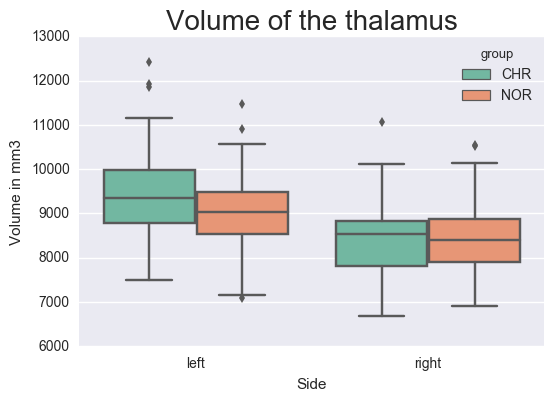

In [60]:
sns.boxplot('side','thalamus_volume', 
            hue='group', 
            palette=sns.color_palette("Set2", 2), 
            data=df_matched[['side','thalamus_volume','group']].drop_duplicates())
plt.title('Volume of the thalamus', fontsize=20)
plt.ylabel('Volume in mm3')
plt.xlabel('Side')
plt.show()

/Users/kangik/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


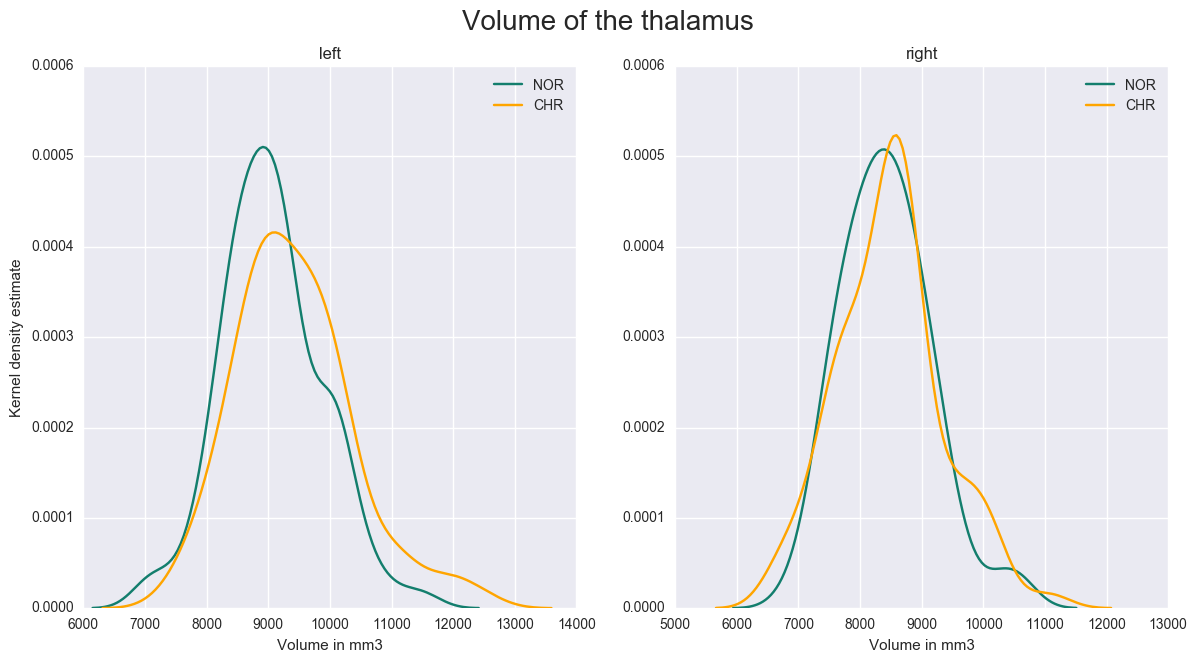

In [68]:
gb = df_matched[['side','thalamus_volume','group']].drop_duplicates().groupby(['group','side'])
var = 'thalamus_volume'

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for num, side in enumerate(['left','right']):
    sns.kdeplot(gb.get_group(('NOR',side))[var], label='NOR', ax=axes[num], color=sns.xkcd_rgb['blue green'])
    sns.kdeplot(gb.get_group(('CHR',side))[var], label='CHR', ax=axes[num], color='orange')
    axes[num].set_title(side)
    axes[num].set_xlabel('Volume in mm3')

fig.suptitle('Volume of the thalamus', fontsize=20)
axes[0].set_ylabel('Kernel density estimate')

plt.show()

             df        sum_sq       mean_sq          F        PR(>F)
GROUP       1.0  4.851624e+06  4.851624e+06   8.201327  4.790320e-03
INTRAVOL    1.0  2.995856e+07  2.995856e+07  50.642823  4.343827e-11
AGE         1.0  5.601953e+05  5.601953e+05   0.946971  3.320688e-01
SEX         1.0  4.745528e+05  4.745528e+05   0.802198  3.718817e-01
Residual  149.0  8.814329e+07  5.915657e+05        NaN           NaN


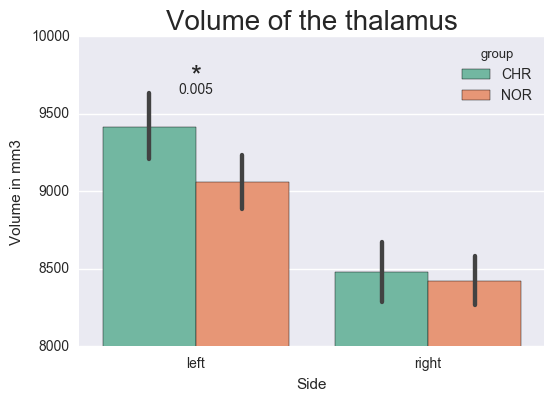

In [69]:
df = df_matched[['subject',
                 'side',
                 'intra_vol',
                 'thalamus_volume',
                 'age',
                 'sex',
                 'group']].drop_duplicates()

ax = sns.barplot('side','thalamus_volume', 
                 hue = 'group', 
                 palette = sns.color_palette("Set2", 2), 
                 data = df)
ax.set_title('Volume of the thalamus', fontsize=20)
ax.set_ylabel('Volume in mm3')
ax.set_ylim(8000, 10000)
ax.set_xlabel('Side')

compare = 'thalamus_volume'

for num, side in enumerate(['left', 'right']):
    x = df.groupby('side').get_group(side)
    GROUP = x['group']
    VAR = x[compare]
    AGE = x['age']
    SEX = x['sex']
    INTRAVOL = x['intra_vol']
    
    formula = 'VAR ~ GROUP + INTRAVOL + AGE + SEX'
    lm = ols(formula, x).fit()
    output = anova_lm(lm)
    if output['PR(>F)'].GROUP < 0.05:
        print(output)
        gb = x.groupby('group')
        
        if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
            group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
        else:
            group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

        ax.annotate("*", 
                    xy=(num, group_mean_upper+group_std_upper/3), 
                    va='center', ha='center', fontsize=20)
        ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                    xy=(num, group_mean_upper+group_std_upper/4), 
                    va='center', ha='center', fontsize=10)
        
plt.show()

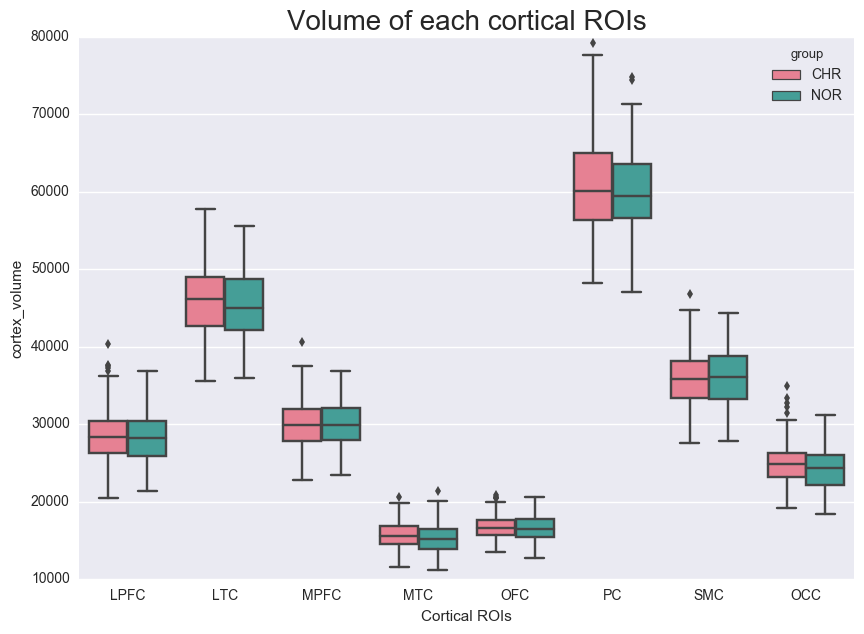

In [70]:
ax = plt.figure(figsize=(10,7))
ax = sns.boxplot('cortex','cortex_volume', 
                 hue='group', 
                 palette=sns.color_palette("husl",2),
                 data=df_matched[['subject', 'cortex','cortex_volume','group']].drop_duplicates())
ax.set_title('Volume of each cortical ROIs', fontsize=20)
ax.set_xlabel('Cortical ROIs')
plt.show()

             df        sum_sq       mean_sq          F        PR(>F)
GROUP       1.0  2.702659e+07  2.702659e+07   4.265739  3.973570e-02
AGE         1.0  9.335310e+06  9.335310e+06   1.473438  2.257462e-01
SEX         1.0  4.332954e+08  4.332954e+08  68.389142  4.239301e-15
Residual  304.0  1.926063e+09  6.335734e+06        NaN           NaN


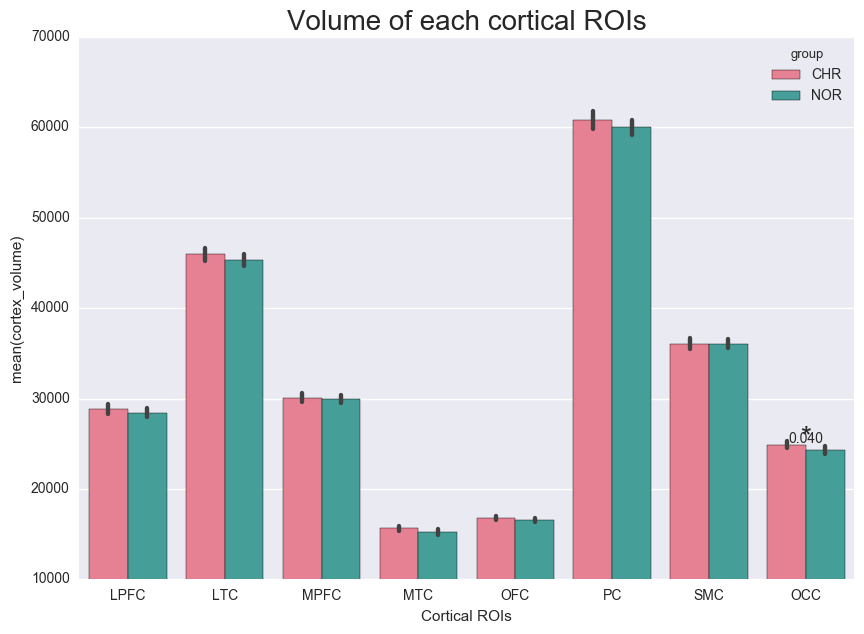

In [71]:
ax = plt.figure(figsize=(10,7))
ax = sns.barplot('cortex','cortex_volume', 
                 hue='group', 
                 palette=sns.color_palette("husl",2),
                 data=df_matched[['subject', 
                                  'cortex', 
                                  'cortex_volume',
                                  'group']].drop_duplicates())
ax.set_ylim(10000, 70000)
ax.set_title('Volume of each cortical ROIs', fontsize=20)
ax.set_xlabel('Cortical ROIs')


compare = 'cortex_volume'
for num, cortex in enumerate(df_matched.cortex.unique()):
    x = df_matched[['subject',
                    'cortex_volume', 
                    'group', 
                    'cortex', 
                    'age', 
                    'sex']].drop_duplicates().groupby('cortex').get_group(cortex)
    GROUP = x['group']
    VAR = x[compare]
    AGE = x['age']
    SEX = x['sex']

    formula = 'VAR ~ GROUP + AGE + SEX'
    lm = ols(formula, x).fit()
    output = anova_lm(lm)
    if output['PR(>F)'].GROUP < 0.05:

        print(output)
        gb = x.groupby('group')

        if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
            group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
        else:
            group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

        conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
        ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

        conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
        ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
#         print(conf_int_a)
#         ax.annotate("*", 
#                     xy=(num, conf_int_a[1]), 
#                     va='center', ha='center', fontsize=20)

plt.show()

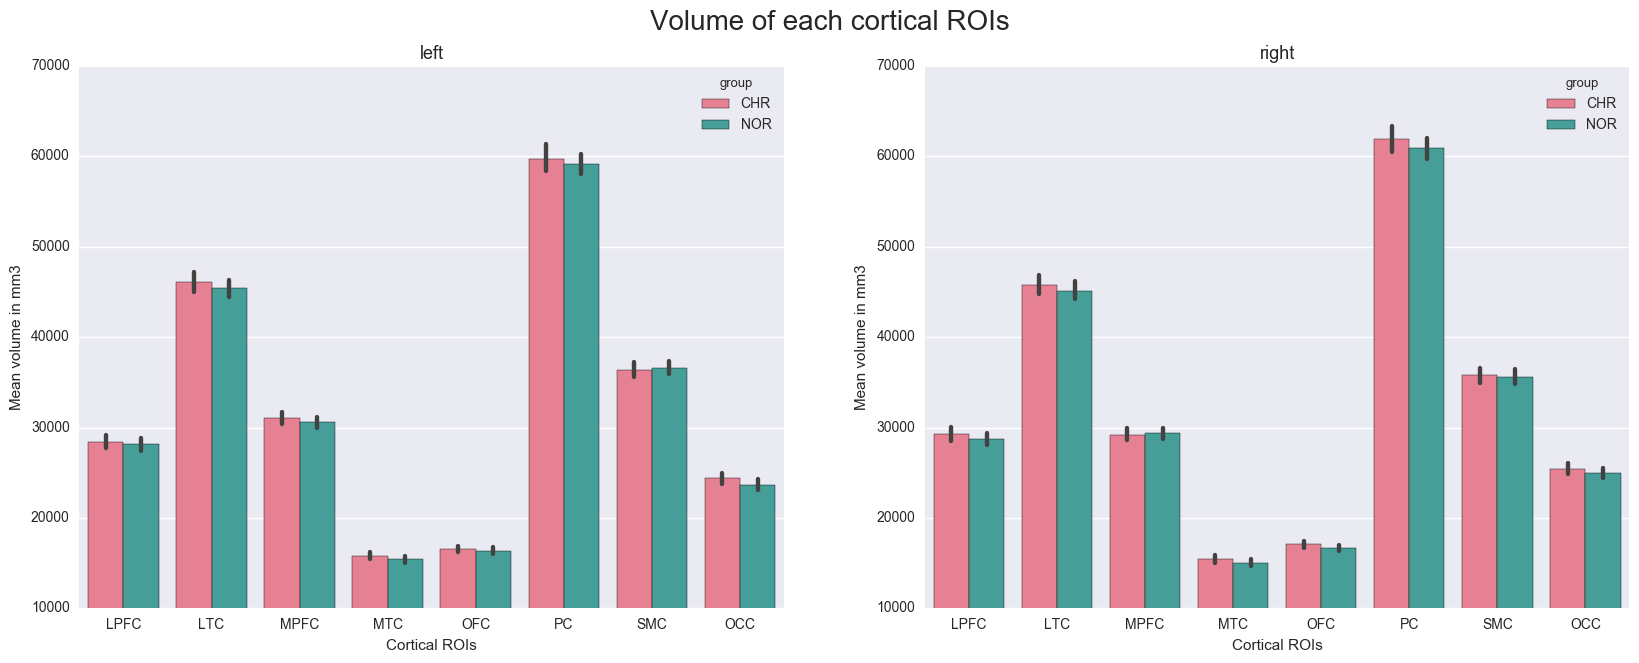

In [72]:
df_gb = df_matched.groupby('side')
fig, axes = plt.subplots(ncols=2, figsize=(20,7))
for side_num, side in enumerate(['left','right']):
    df = df_gb.get_group(side)[['cortex',
                                'cortex_volume',
                                'subject',
                                'group',
                                'age',
                                'sex']].drop_duplicates()
    
    sns.barplot('cortex',
                'cortex_volume',
                hue='group', 
                palette=sns.color_palette("husl",2),
                data=df, 
                ax=axes[side_num])
    
    axes[side_num].set_ylim(10000, 70000)
    axes[side_num].set_title(side, fontsize=13)
    axes[side_num].set_xlabel('Cortical ROIs')
    axes[side_num].set_ylabel('Mean volume in mm3')

    compare = 'cortex_volume'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df.groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        
        # If there is significant group effect
        if output['PR(>F)'].GROUP < 0.05:
            print(output)
            gb = x.groupby('group')
            groups = list(gb.groups.keys())

            # Determine the upper boundary of the plot
            # If the first group has higher mean than the second group
            if gb.get_group(groups[0])[compare].mean() > gb.get_group(groups[1])[compare].mean():
                group_mean_upper = gb.get_group(groups[0])[compare].mean()
                group_std_upper = gb.get_group(groups[0])[compare].std()
            # If the second group has higher mean than the second group
            else:
                group_mean_upper = gb.get_group(groups[1])[compare].mean()
                group_std_upper = gb.get_group(groups[1])[compare].std()
            
            # Estimate confidence interval
            # Edit here to make the significant sign higher up from the bar plot
            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            axes[side_num].annotate('*', 
                                    xy=(num, conf_int_a[1]), 
                                    va='center', 
                                    ha='center', 
                                    fontsize=20)
            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            axes[side_num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                    xy=(num, conf_int_a[1]), 
                                    va='center', 
                                    ha='center', 
                                    fontsize=10)
            
fig.suptitle('Volume of each cortical ROIs', fontsize=20)
plt.show()


In [73]:
df_matched.head()

,subject,side,cortex,threshold,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness
8,CHR04,left,LPFC,10,1.563779e+06,30171,10032,421,0.848836,221381.070583,2932619.0,0.118277,CHR,CHR04_PJH,1,24,1
9,CHR04,left,LTC,10,1.563779e+06,47297,10032,896,0.811619,142687.300251,1889038.0,0.076188,CHR,CHR04_PJH,1,24,1
10,CHR04,left,MPFC,10,1.563779e+06,30242,10032,781,0.761892,168072.803107,2253434.0,0.090885,CHR,CHR04_PJH,1,24,1
11,CHR04,left,MTC,10,1.563779e+06,18015,10032,905,0.791176,177102.900765,2498761.0,0.100779,CHR,CHR04_PJH,1,24,1
12,CHR04,left,OFC,10,1.563779e+06,16580,10032,642,0.811548,537095.025159,7005886.0,0.282559,CHR,CHR04_PJH,1,24,1


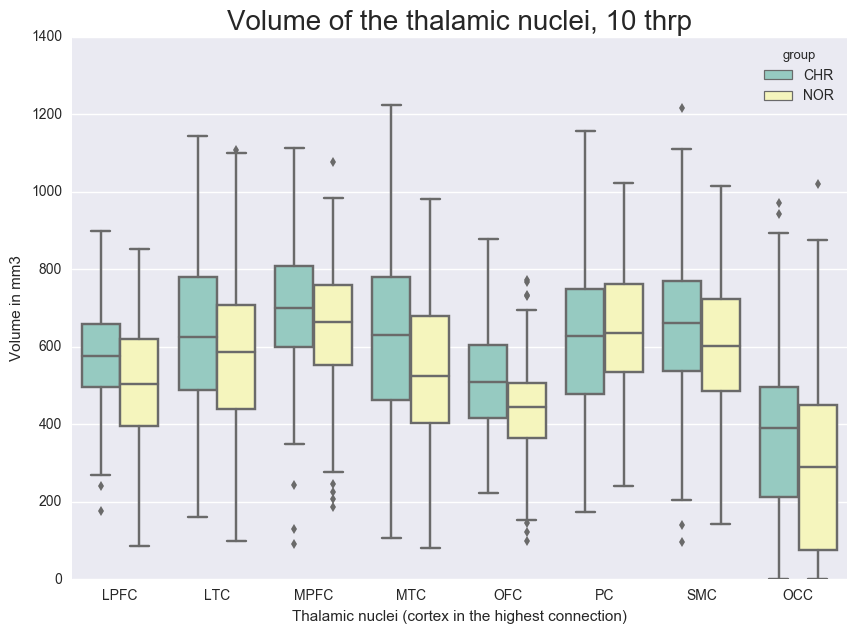

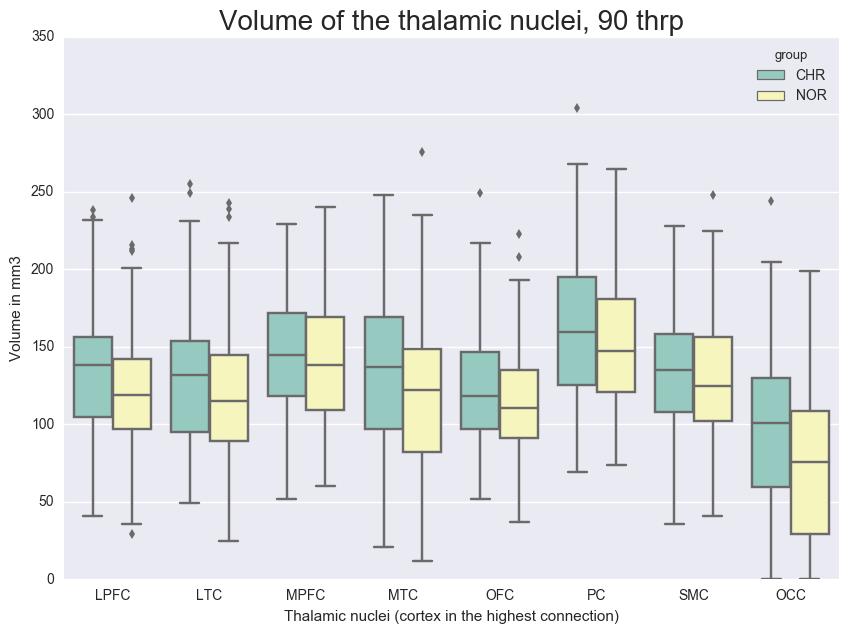

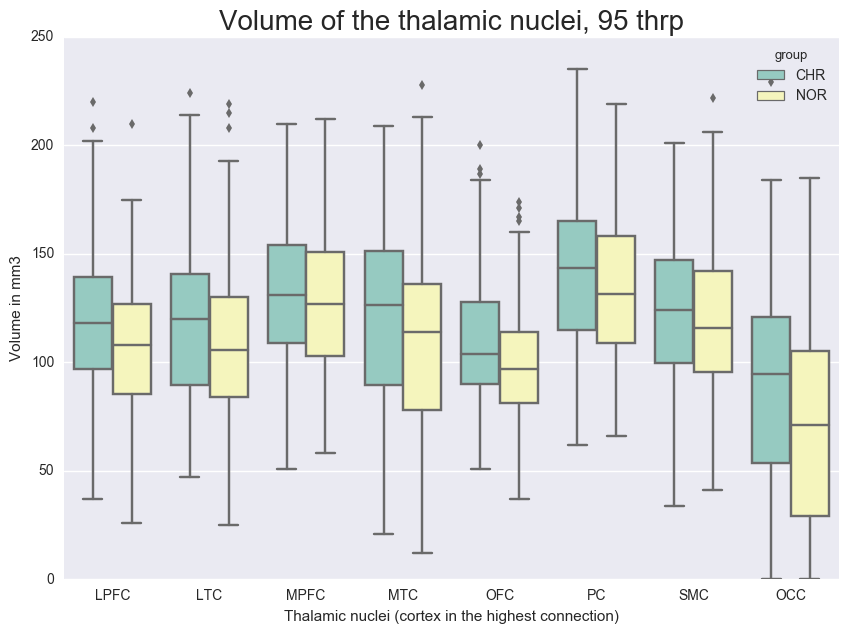

In [74]:
for thr in '10', '90', '95':
#     mk = 'Volume_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.boxplot('cortex', 'thalamus_seg_volume', 
                     hue='group', palette=sns.color_palette("Set3", 2),
                data=df_matched[['subject',
                                 'cortex',
                                 'thalamus_seg_volume',
                                 'group',
                                 'threshold']].drop_duplicates().groupby('threshold').get_group(thr))     

    ax.set_title('Volume of the thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Volume in mm3')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    
    plt.show()

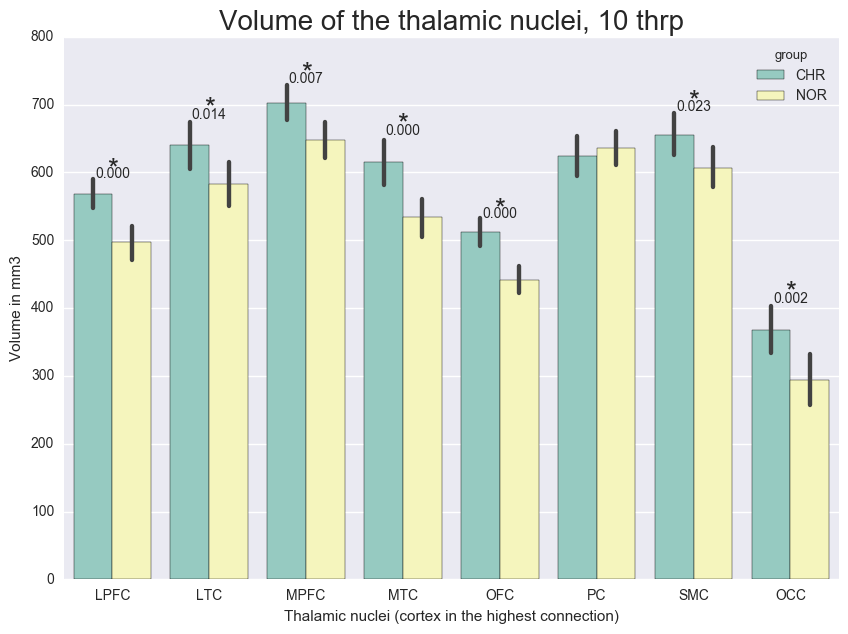

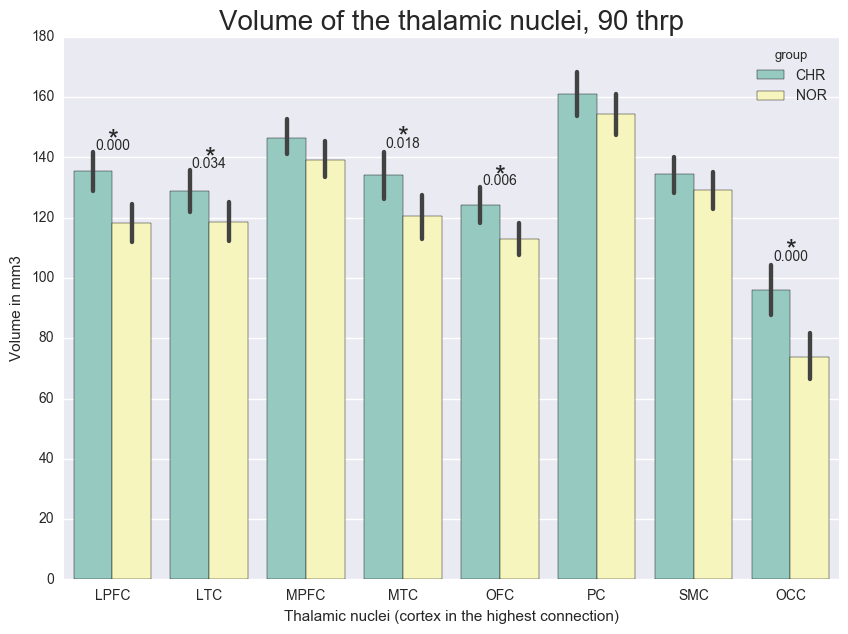

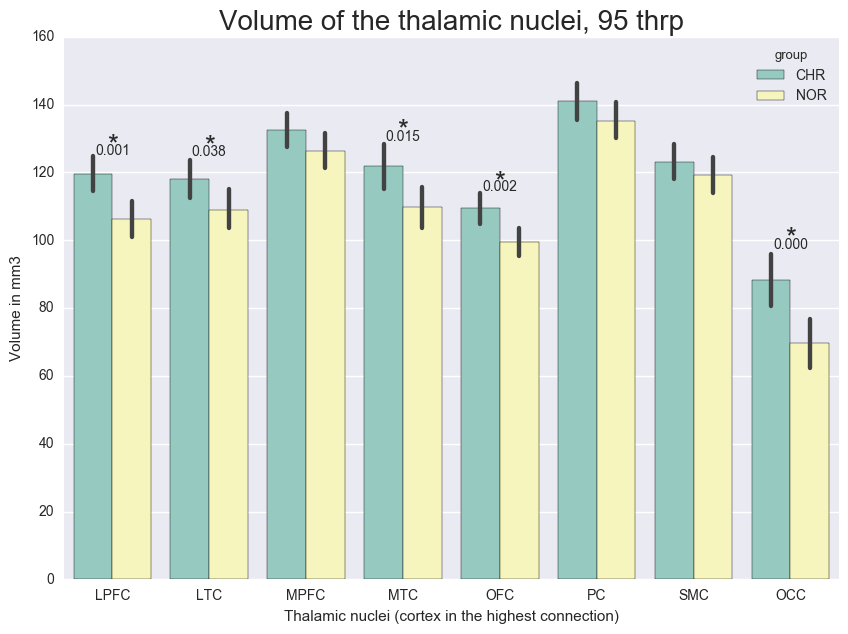

In [75]:
for thr in '10', '90', '95':
#     volume = 'Volume_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.barplot('cortex', 'thalamus_seg_volume', 
                     hue='group', palette=sns.color_palette("Set3", 2),
                data=df_matched[['subject',
                                 'cortex',
                                 'thalamus_seg_volume',
                                 'group',
                                 'threshold']].drop_duplicates().groupby('threshold').get_group(thr))     

    ax.set_title('Volume of the thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Volume in mm3')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    
    
    compare = 'thalamus_seg_volume'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_matched[['subject',
                        'cortex',
                        'thalamus_seg_volume',
                        'age',
                        'sex',
                        'group',
                        'threshold']].drop_duplicates().groupby(['cortex','threshold']).get_group((cortex, thr))
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:

    #         print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #         print(conf_int_a)
    #         ax.annotate("*", 
    #                     xy=(num, conf_int_a[1]), 
    #                     va='center', ha='center', fontsize=20)

    plt.show()

In [76]:
df_matched.head()

,subject,side,cortex,threshold,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness
8,CHR04,left,LPFC,10,1.563779e+06,30171,10032,421,0.848836,221381.070583,2932619.0,0.118277,CHR,CHR04_PJH,1,24,1
9,CHR04,left,LTC,10,1.563779e+06,47297,10032,896,0.811619,142687.300251,1889038.0,0.076188,CHR,CHR04_PJH,1,24,1
10,CHR04,left,MPFC,10,1.563779e+06,30242,10032,781,0.761892,168072.803107,2253434.0,0.090885,CHR,CHR04_PJH,1,24,1
11,CHR04,left,MTC,10,1.563779e+06,18015,10032,905,0.791176,177102.900765,2498761.0,0.100779,CHR,CHR04_PJH,1,24,1
12,CHR04,left,OFC,10,1.563779e+06,16580,10032,642,0.811548,537095.025159,7005886.0,0.282559,CHR,CHR04_PJH,1,24,1


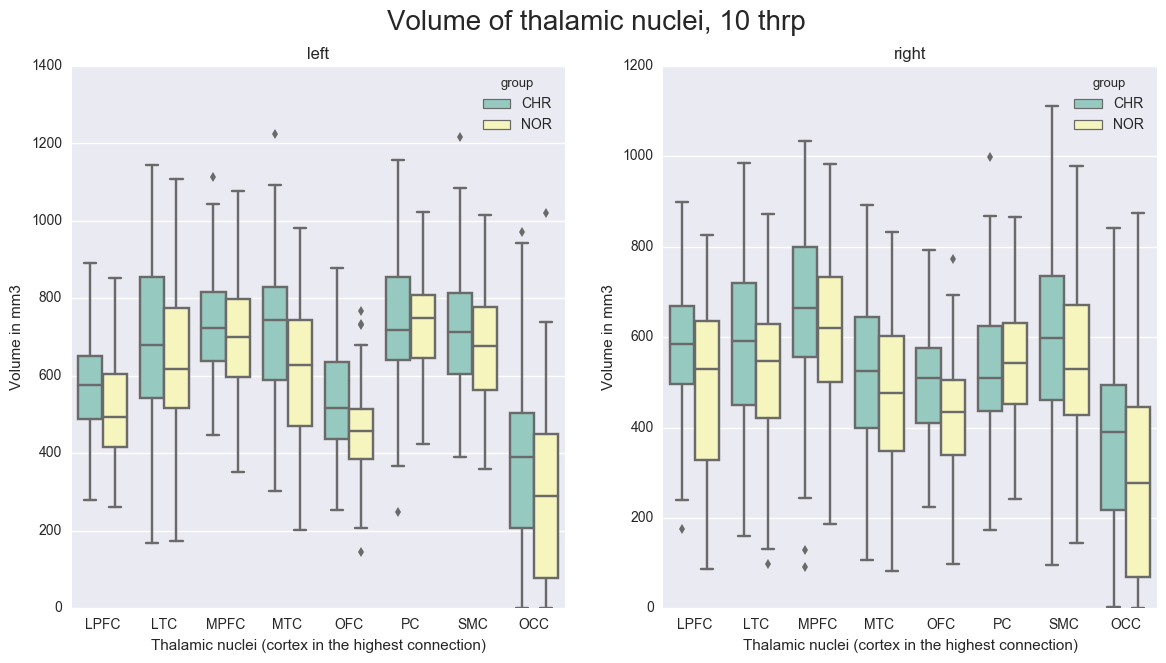

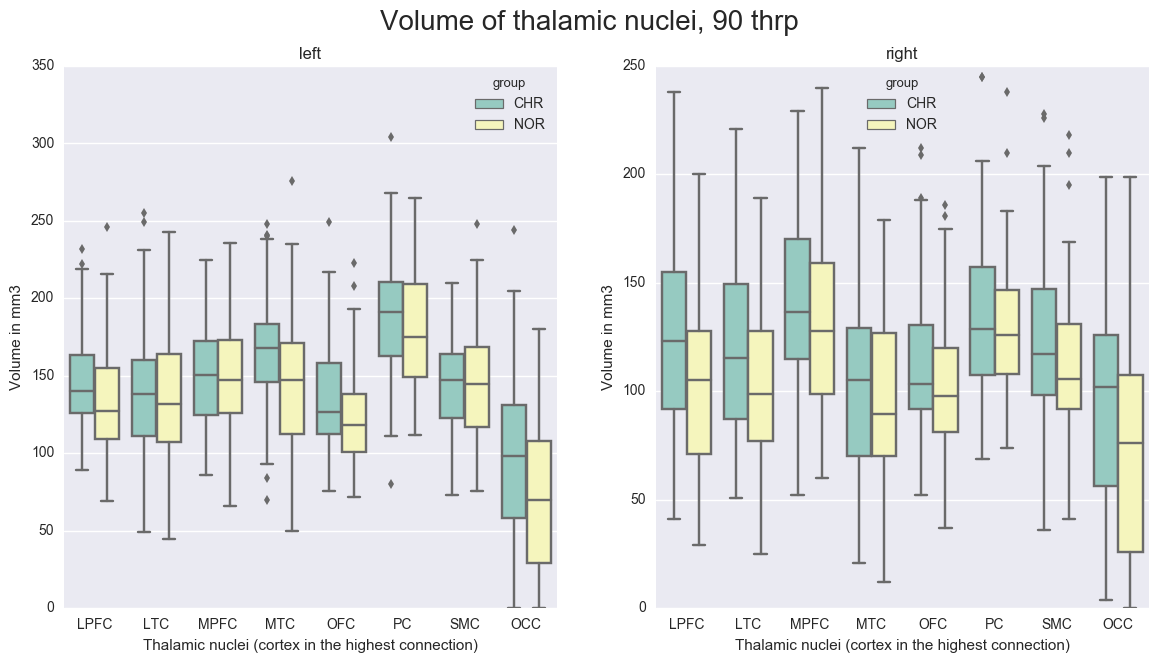

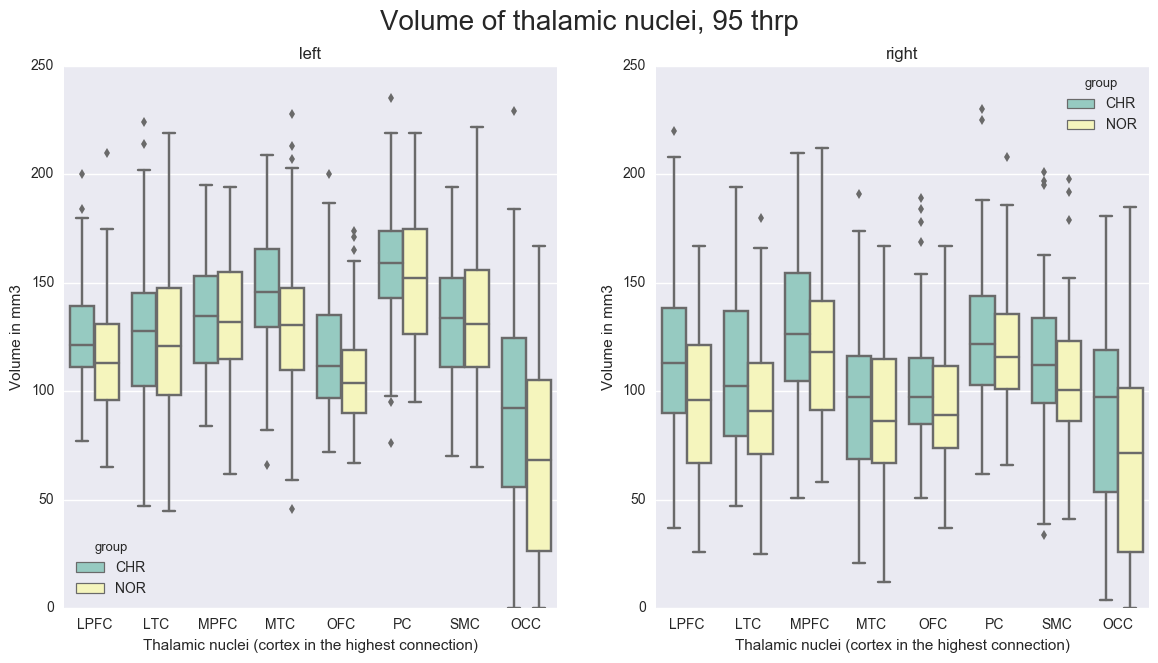

In [77]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.boxplot('cortex', 
                    'thalamus_seg_volume',
                    hue='group', 
                    palette=sns.color_palette("Set3", 2),
                    data=df_matched[['subject','side','cortex','threshold','group',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                    ax=axes[num])
        axes[num].set_ylabel('Volume in mm3')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)


    fig.suptitle('Volume of thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

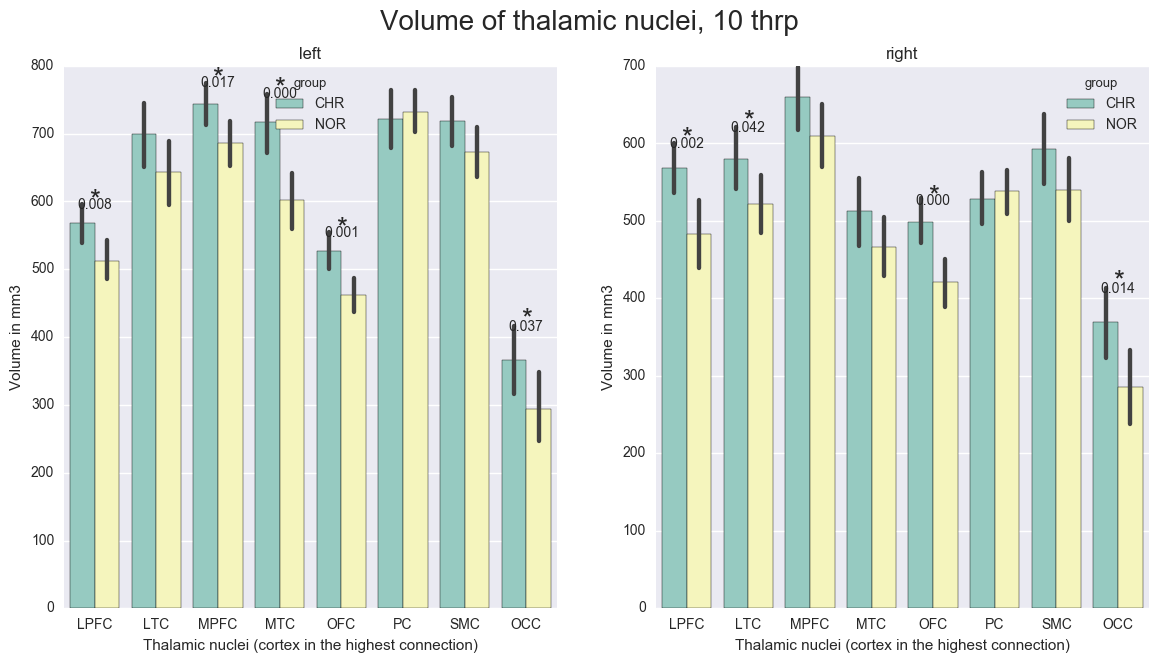

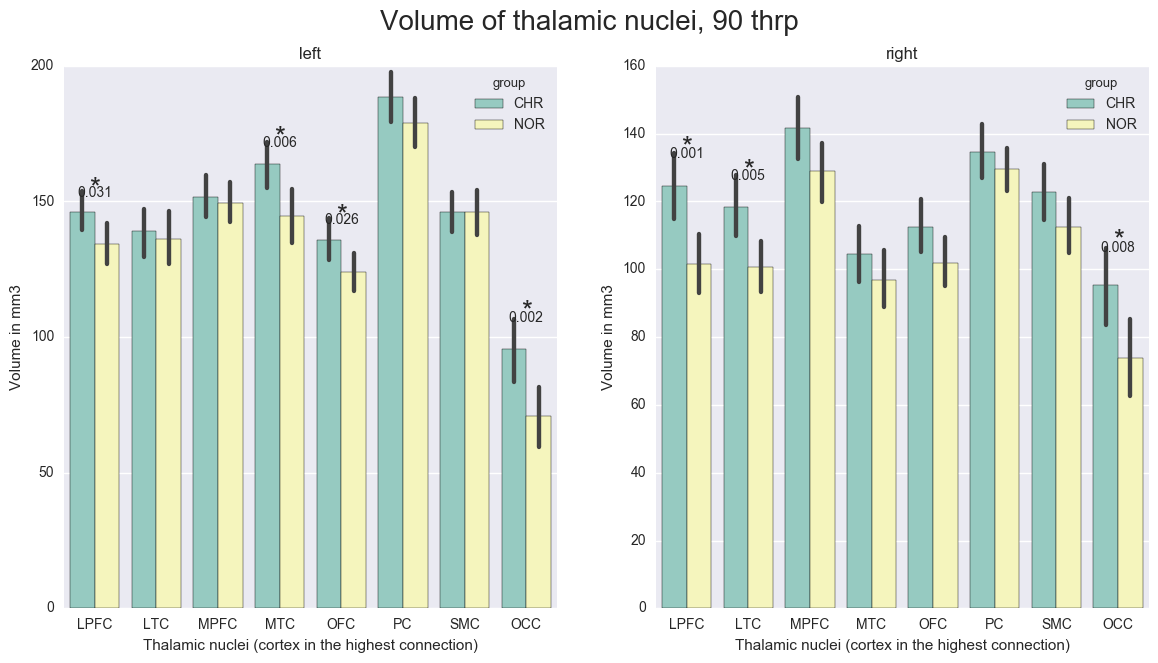

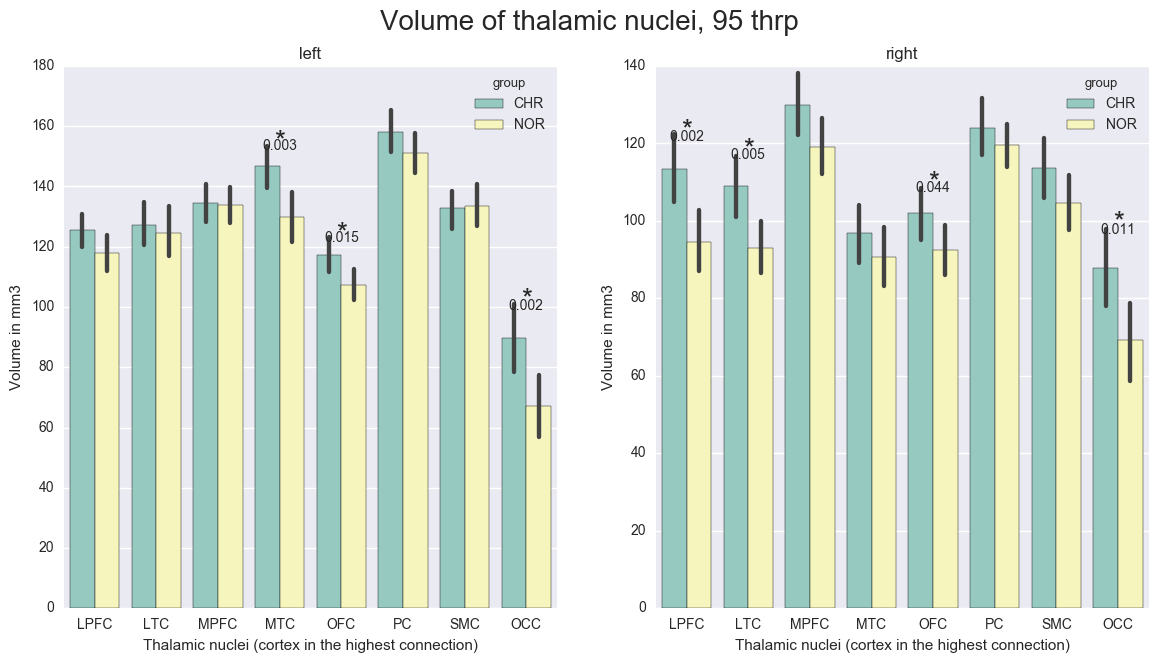

In [78]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'thalamus_seg_volume',
                    hue='group', 
                    palette=sns.color_palette("Set3", 2),
                    data=df_matched[['subject','side','cortex','threshold','group',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                    ax=axes[num])
        axes[num].set_ylabel('Volume in mm3')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        

        compare = 'thalamus_seg_volume'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_matched[['subject','side','cortex','threshold','group','age','sex',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold','cortex']).get_group((side, thr, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
        #         print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)

    fig.suptitle('Volume of thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

In [79]:
df_matched.head()

,subject,side,cortex,threshold,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness
8,CHR04,left,LPFC,10,1.563779e+06,30171,10032,421,0.848836,221381.070583,2932619.0,0.118277,CHR,CHR04_PJH,1,24,1
9,CHR04,left,LTC,10,1.563779e+06,47297,10032,896,0.811619,142687.300251,1889038.0,0.076188,CHR,CHR04_PJH,1,24,1
10,CHR04,left,MPFC,10,1.563779e+06,30242,10032,781,0.761892,168072.803107,2253434.0,0.090885,CHR,CHR04_PJH,1,24,1
11,CHR04,left,MTC,10,1.563779e+06,18015,10032,905,0.791176,177102.900765,2498761.0,0.100779,CHR,CHR04_PJH,1,24,1
12,CHR04,left,OFC,10,1.563779e+06,16580,10032,642,0.811548,537095.025159,7005886.0,0.282559,CHR,CHR04_PJH,1,24,1


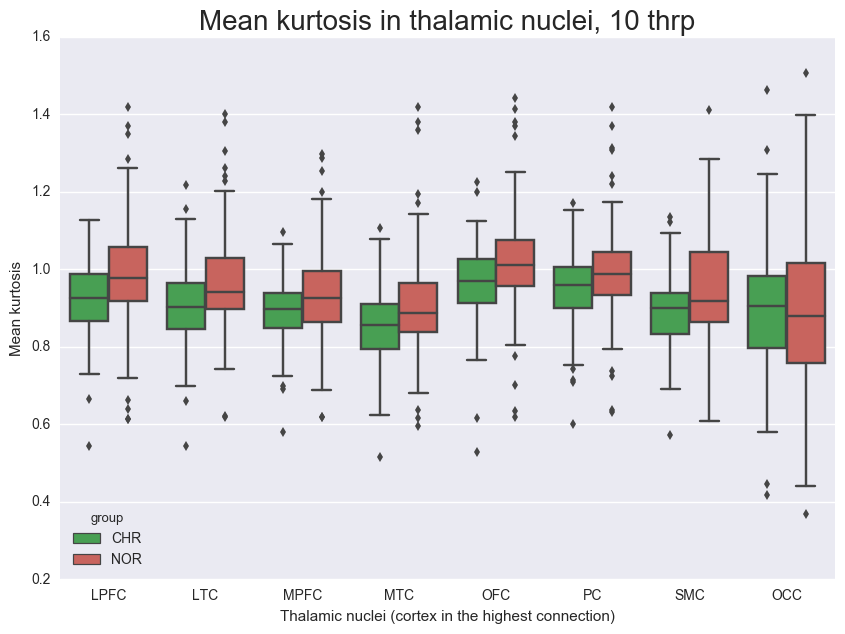

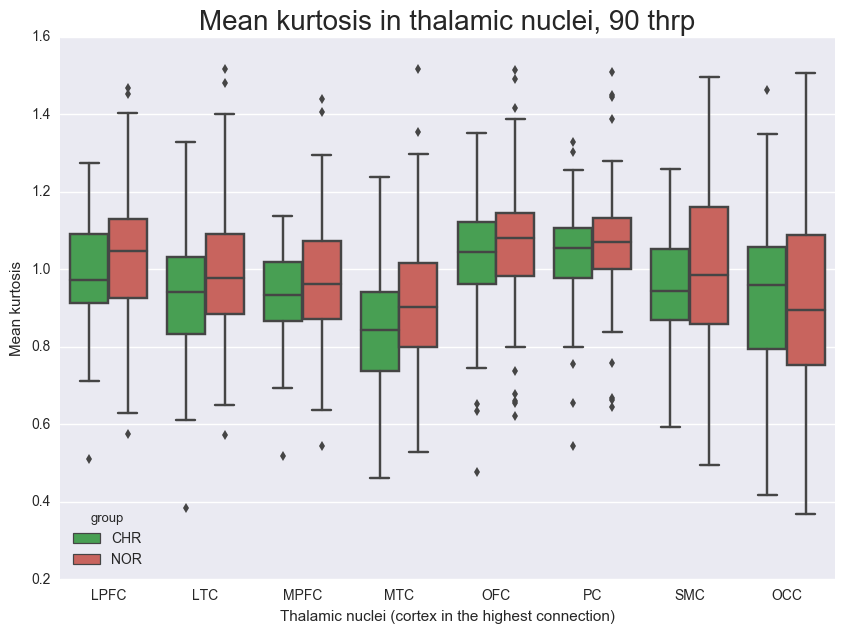

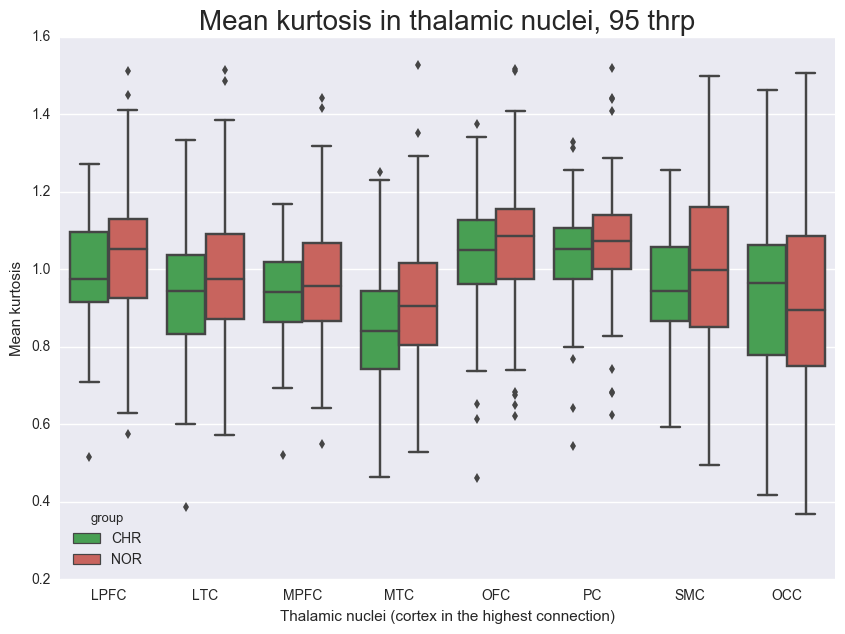

In [80]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    ax = plt.figure(figsize=(10,7))
    ax = sns.boxplot('cortex',
                     'thalamus_seg_mk',
                     hue='group', 
                     palette=sns.xkcd_palette(['medium green','pale red']),
                     data = df_gb.get_group(thr))     

    ax.set_title('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Mean kurtosis')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    plt.show()

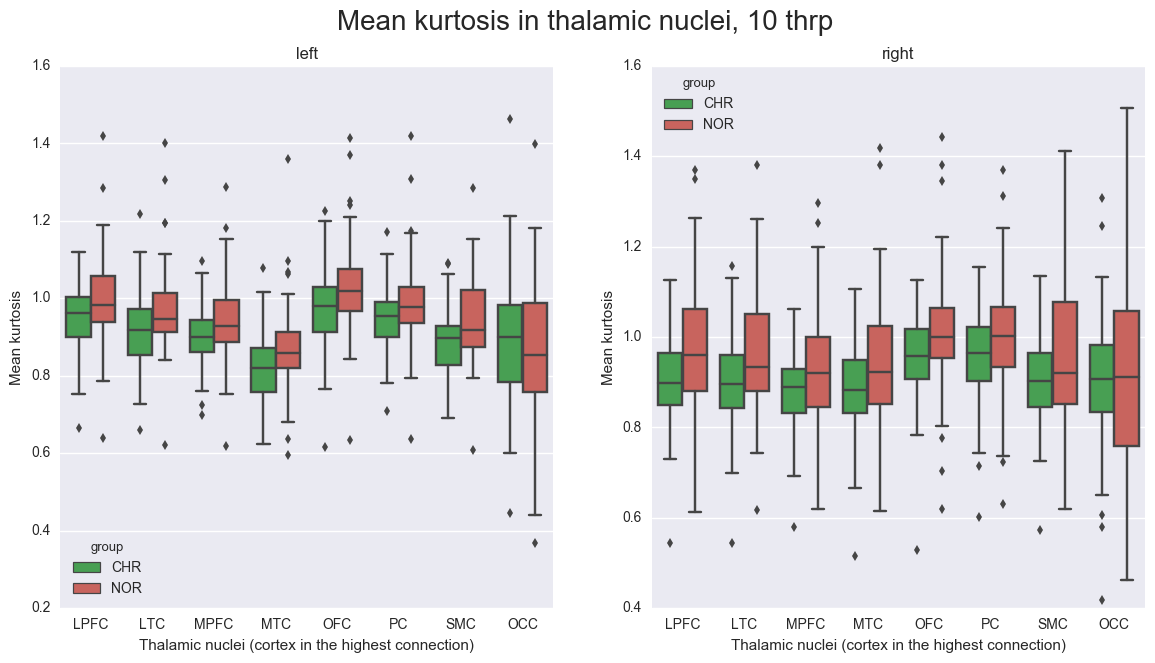

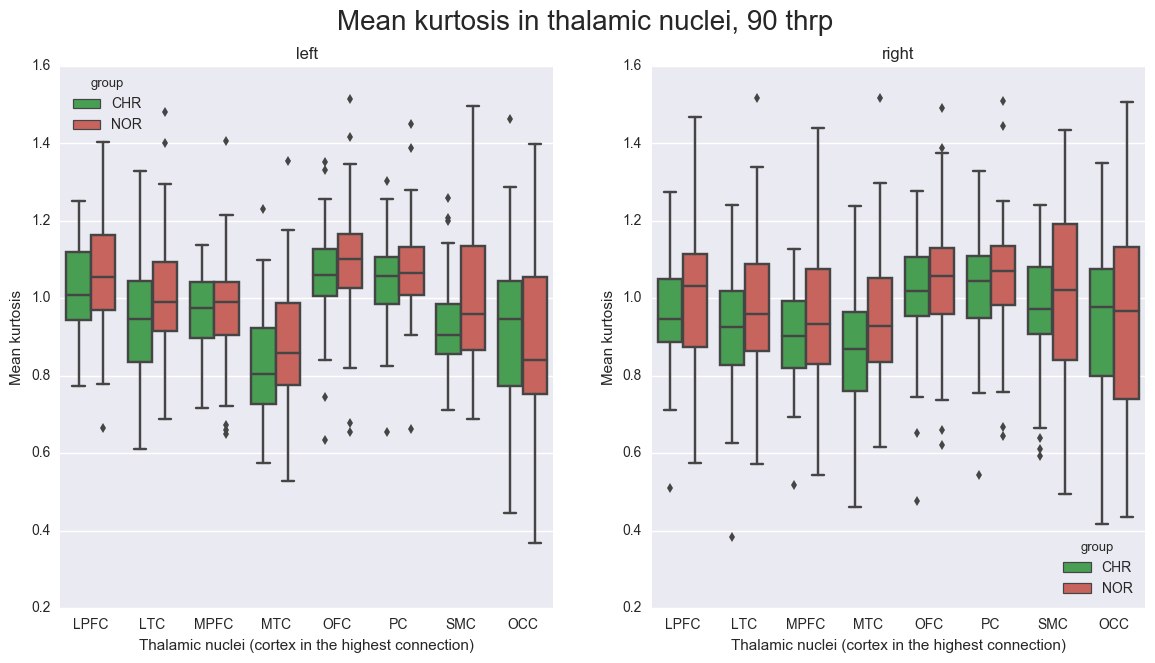

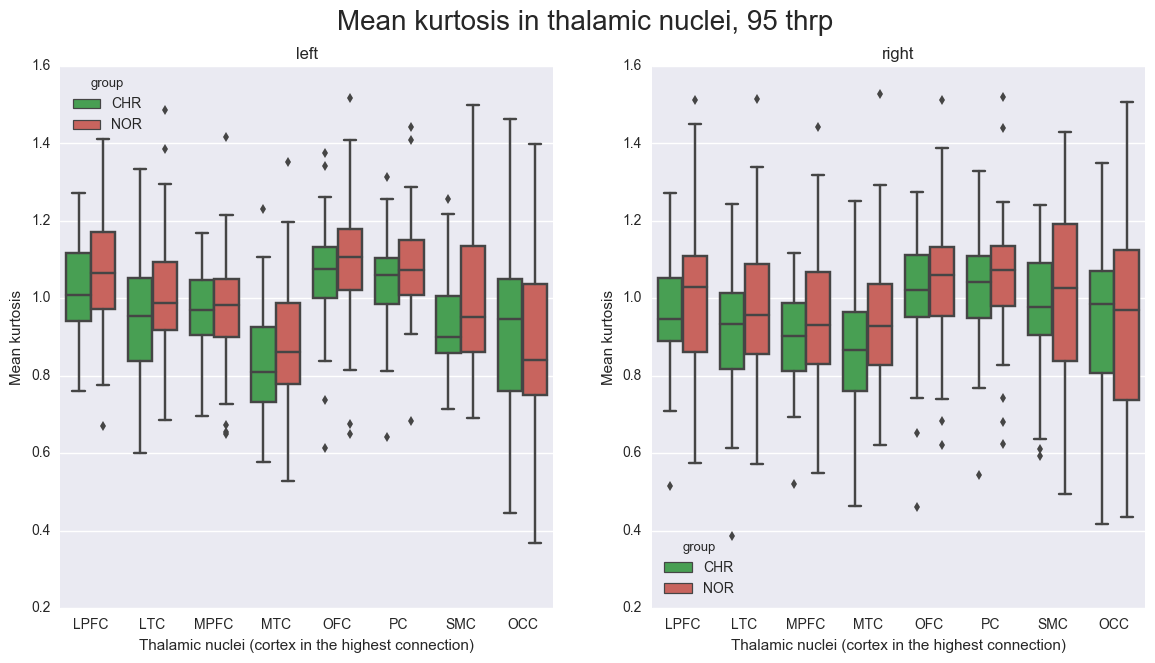

In [81]:
df_gb = df_matched.groupby(['threshold', 'side'])

for thr in '10', '90', '95':
    mk = 'mk_'+thr
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.boxplot('cortex', 
                    'thalamus_seg_mk',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Mean kurtosis')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        

    fig.suptitle('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

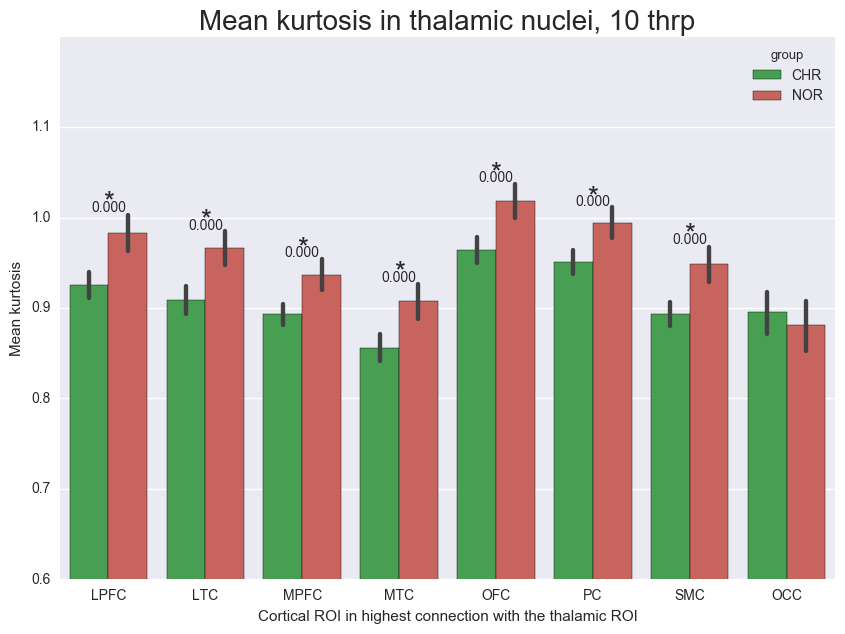

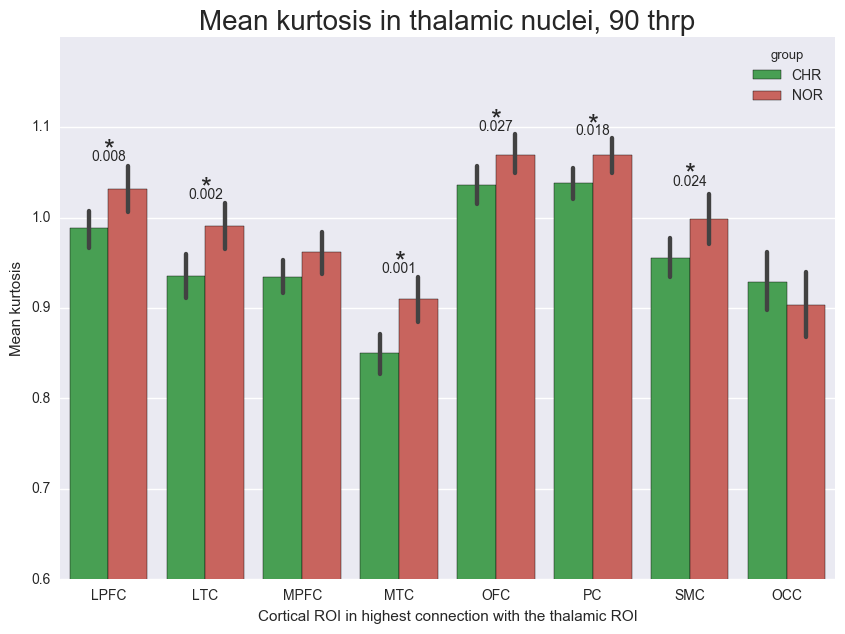

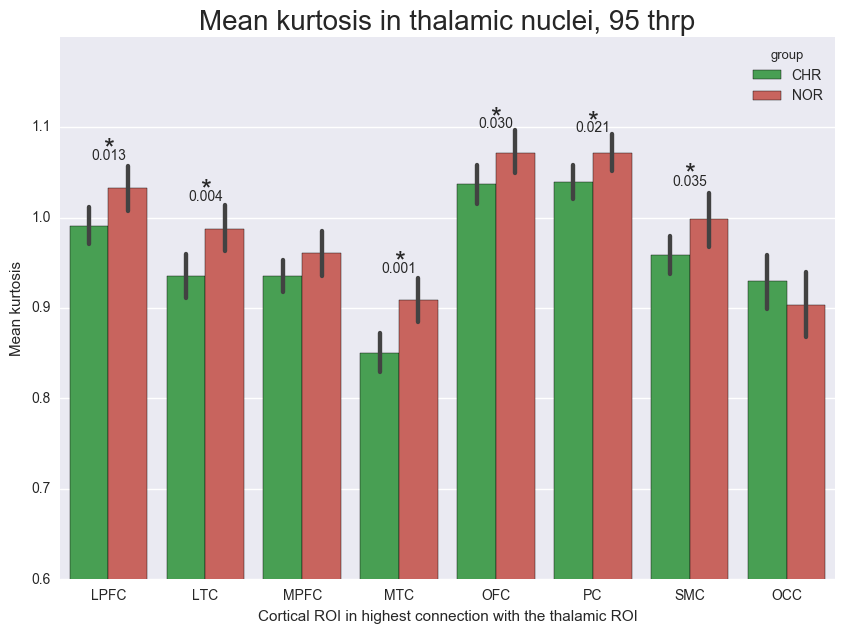

In [82]:
df_gb = df_matched.groupby('threshold')

for thr in '10', '90', '95':
    mk = 'mk_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.barplot('cortex', 
                     'thalamus_seg_mk', 
                     hue='group', 
                     palette=sns.xkcd_palette(['medium green','pale red']),
                     data=df_gb.get_group(thr))     
    ax.set_ylim(0.6, 1.2)
    ax.set_title('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Mean kurtosis')
    ax.set_xlabel('Cortical ROI in highest connection with the thalamic ROI')
    
    compare = 'thalamus_seg_mk'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_gb.get_group(thr).groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:

    #         print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #         print(conf_int_a)
    #         ax.annotate("*", 
    #                     xy=(num, conf_int_a[1]), 
    #                     va='center', ha='center', fontsize=20)

    plt.show()

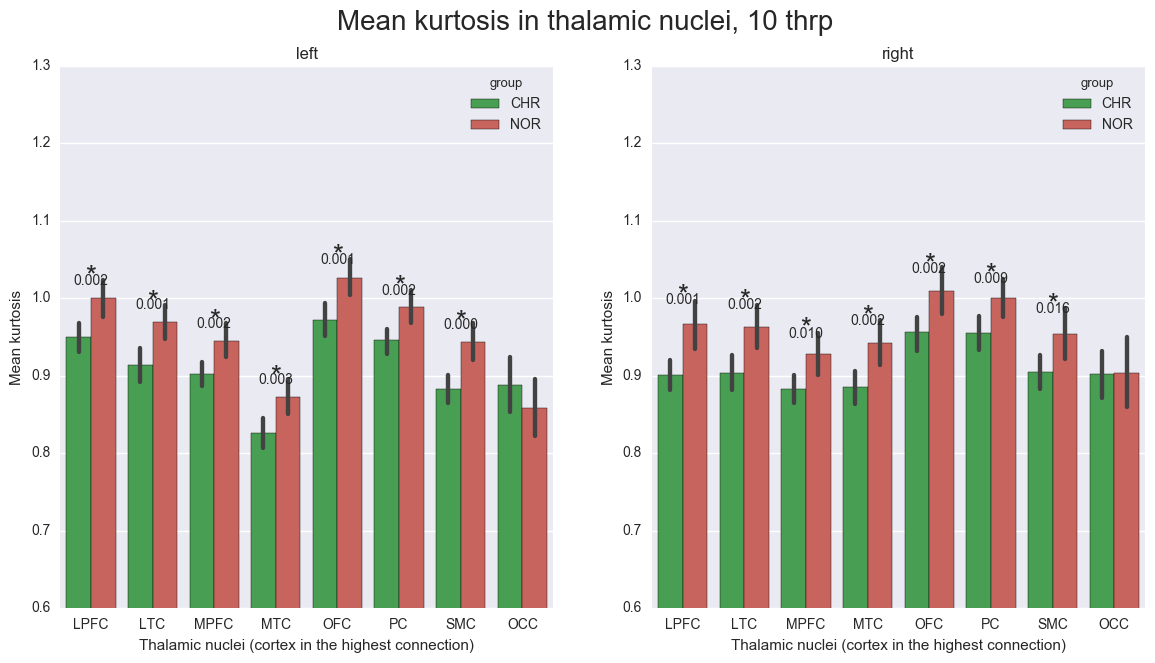

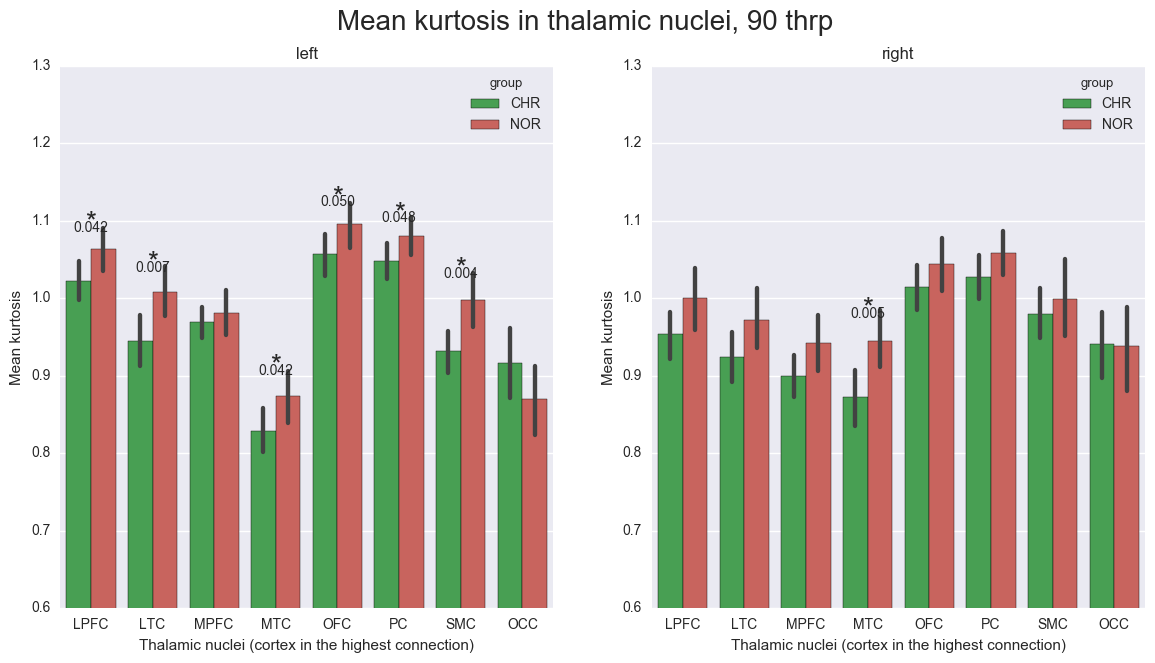

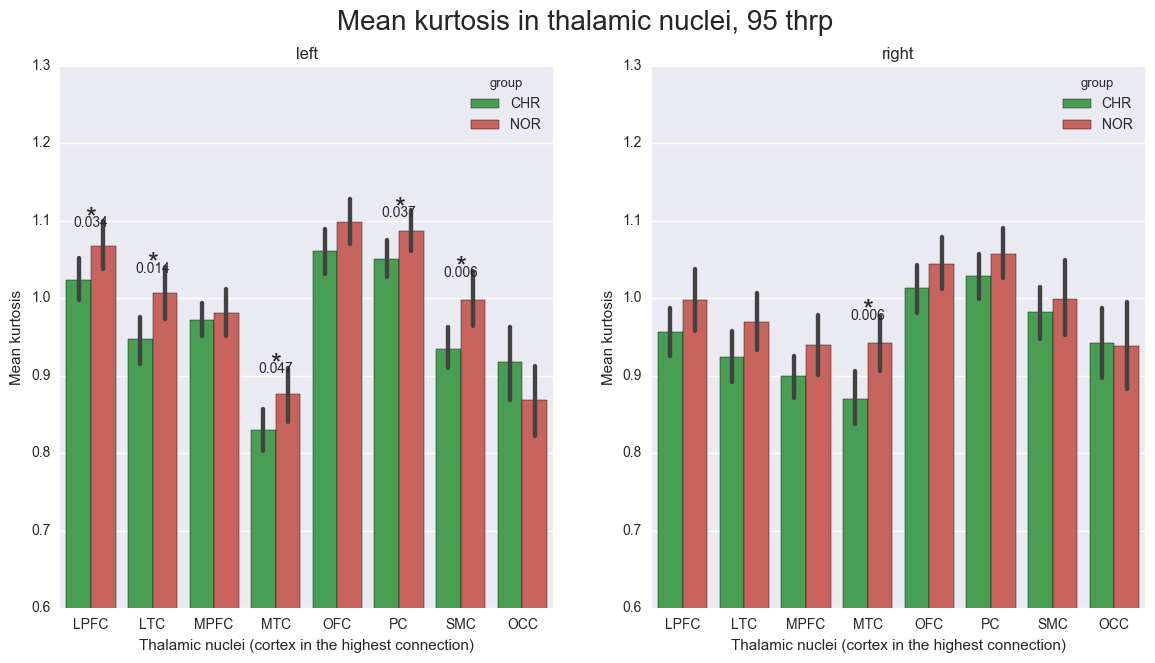

In [83]:
df_gb = df_matched.groupby(['threshold', 'side'])

for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'thalamus_seg_mk',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Mean kurtosis')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        axes[num].set_ylim(0.6, 1.3)

        compare = 'thalamus_seg_mk'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)÷
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

In [84]:
df_matched.head()

,subject,side,cortex,threshold,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness
8,CHR04,left,LPFC,10,1.563779e+06,30171,10032,421,0.848836,221381.070583,2932619.0,0.118277,CHR,CHR04_PJH,1,24,1
9,CHR04,left,LTC,10,1.563779e+06,47297,10032,896,0.811619,142687.300251,1889038.0,0.076188,CHR,CHR04_PJH,1,24,1
10,CHR04,left,MPFC,10,1.563779e+06,30242,10032,781,0.761892,168072.803107,2253434.0,0.090885,CHR,CHR04_PJH,1,24,1
11,CHR04,left,MTC,10,1.563779e+06,18015,10032,905,0.791176,177102.900765,2498761.0,0.100779,CHR,CHR04_PJH,1,24,1
12,CHR04,left,OFC,10,1.563779e+06,16580,10032,642,0.811548,537095.025159,7005886.0,0.282559,CHR,CHR04_PJH,1,24,1


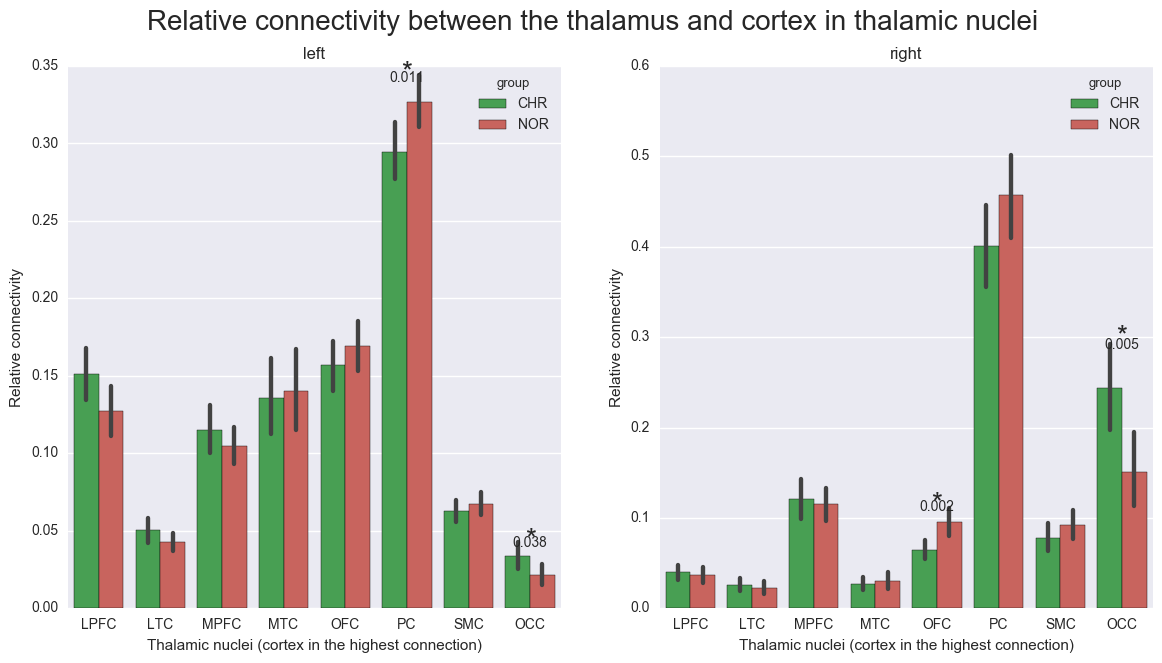

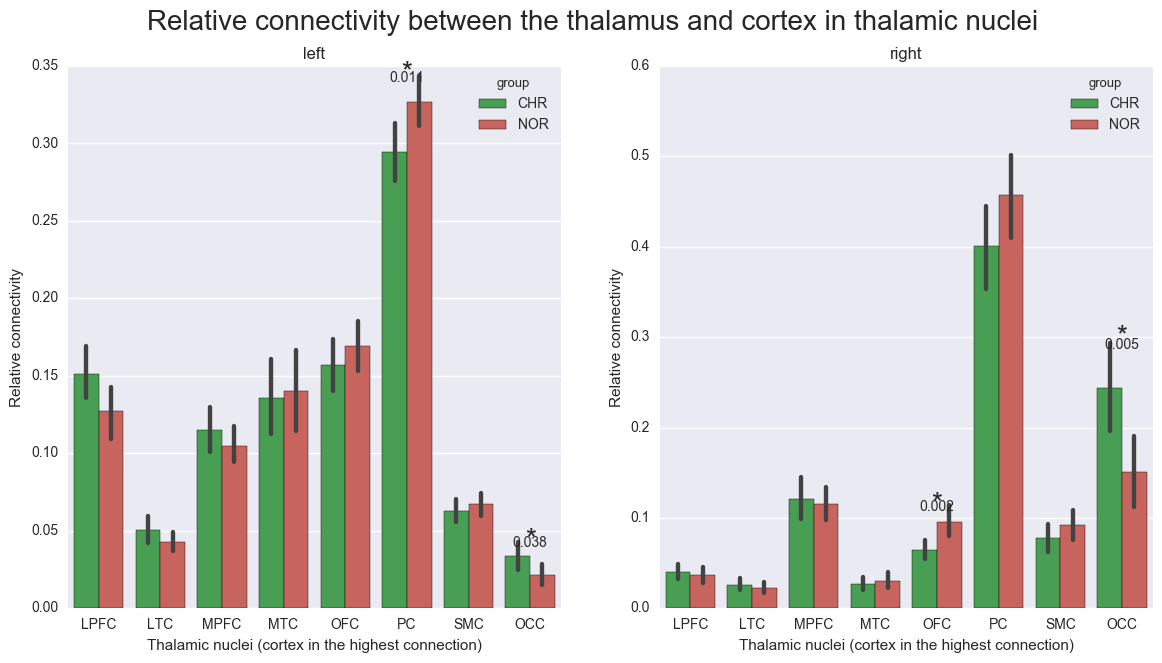

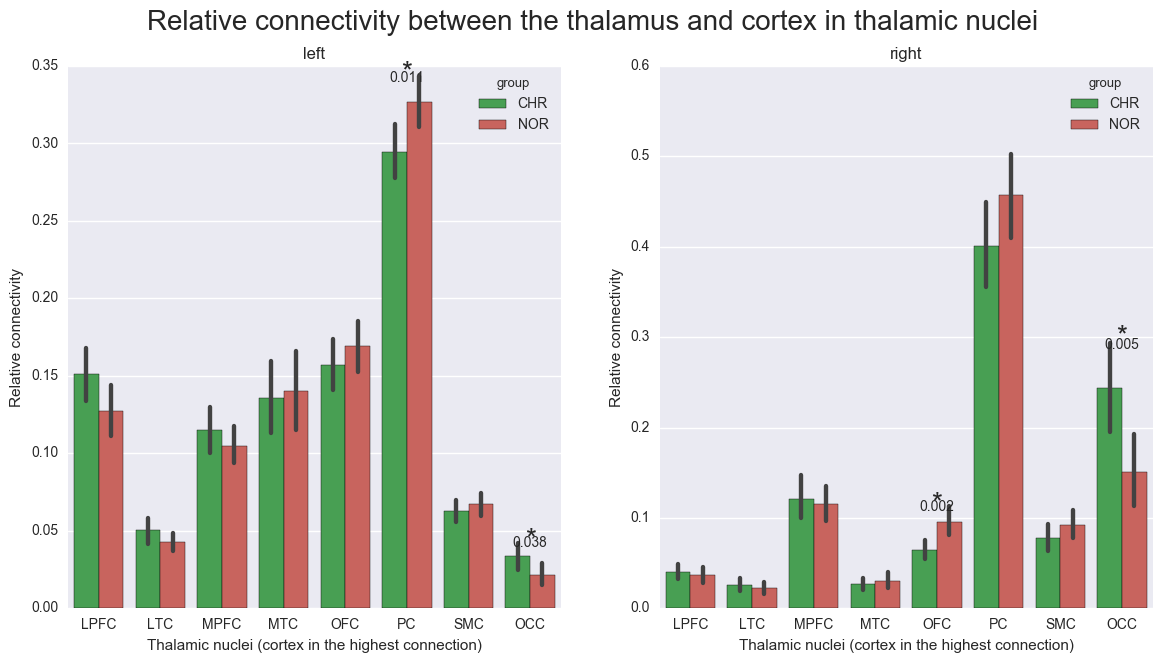

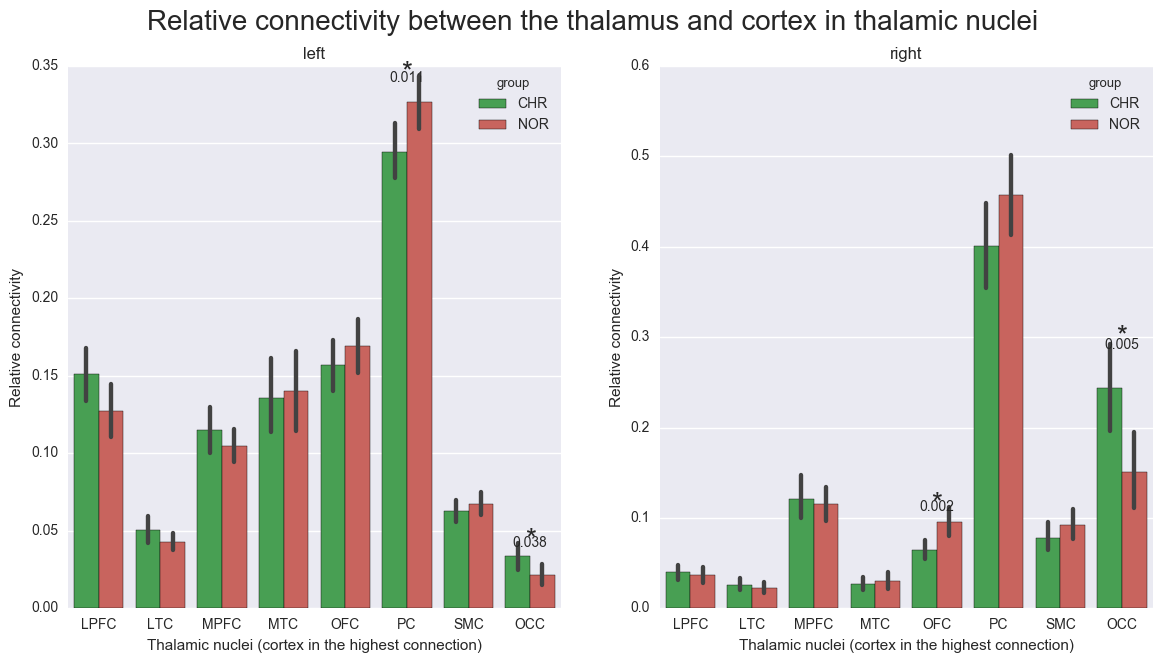

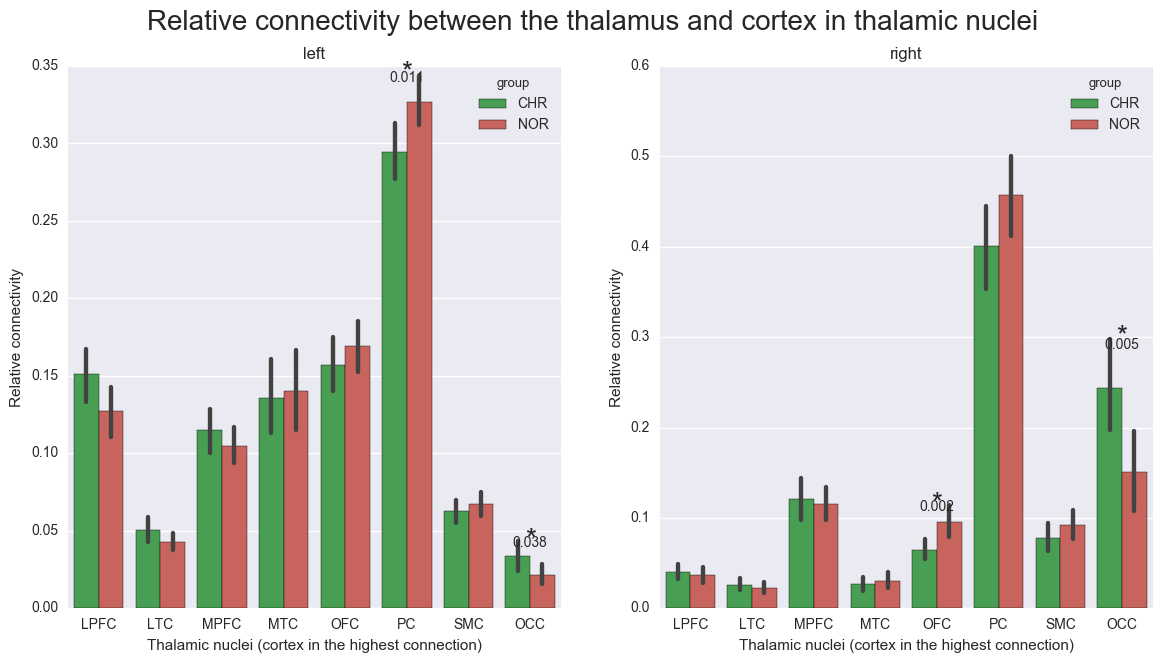

In [85]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'relative_connectivity',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Relative connectivity')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)

        compare = 'relative_connectivity'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
    #                 print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle('Relative connectivity between the thalamus and cortex in thalamic nuclei'.format(thr), fontsize=20)
    plt.show()

In [86]:
df_matched.groupby('threshold').mean()

,intra_vol,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,sex,age,handedness
threshold,,,,,,,,,,,
10,1.618689e+06,32180.25974,8844.792208,557.131494,0.932954,119162.996835,1.607790e+06,0.125,1.305195,21.714286,1.077922
20,1.618689e+06,32180.25974,8844.792208,427.899351,0.947040,107969.415651,1.607790e+06,0.125,1.305195,21.714286,1.077922
5,1.618689e+06,32180.25974,8844.792208,674.394886,0.919860,125034.620983,1.607790e+06,0.125,1.305195,21.714286,1.077922
90,1.618689e+06,32180.25974,8844.792208,126.556006,0.975399,29890.028295,1.607790e+06,0.125,1.305195,21.714286,1.077922
95,1.618689e+06,32180.25974,8844.792208,114.212662,0.976090,24713.647244,1.607790e+06,0.125,1.305195,21.714286,1.077922


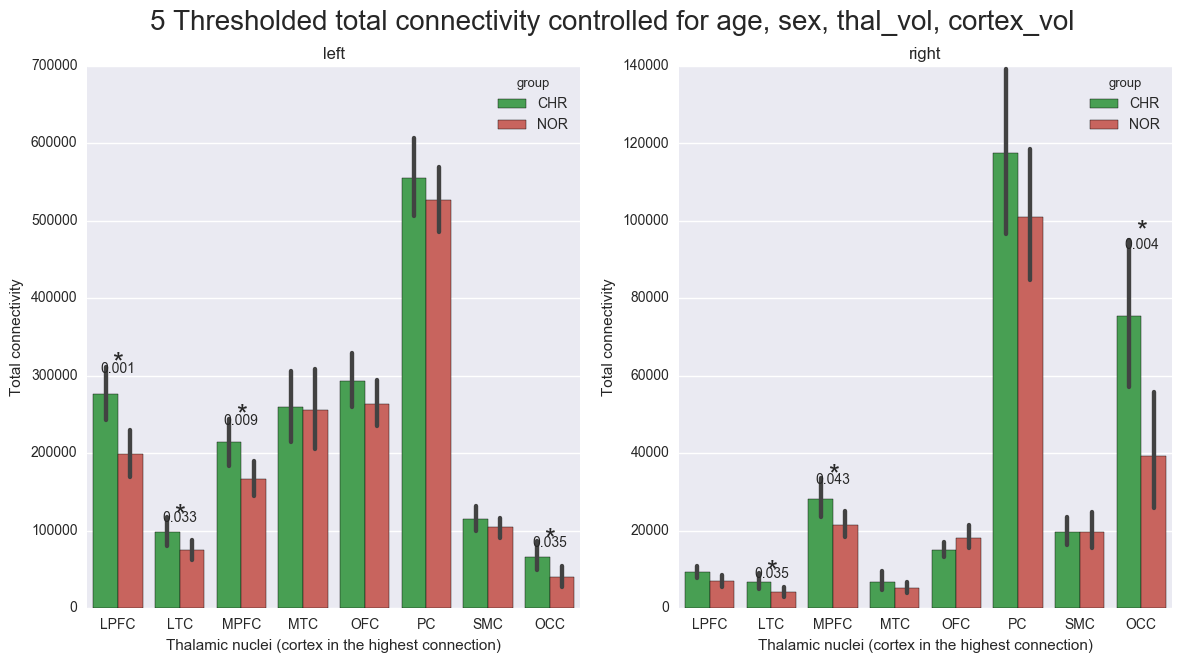

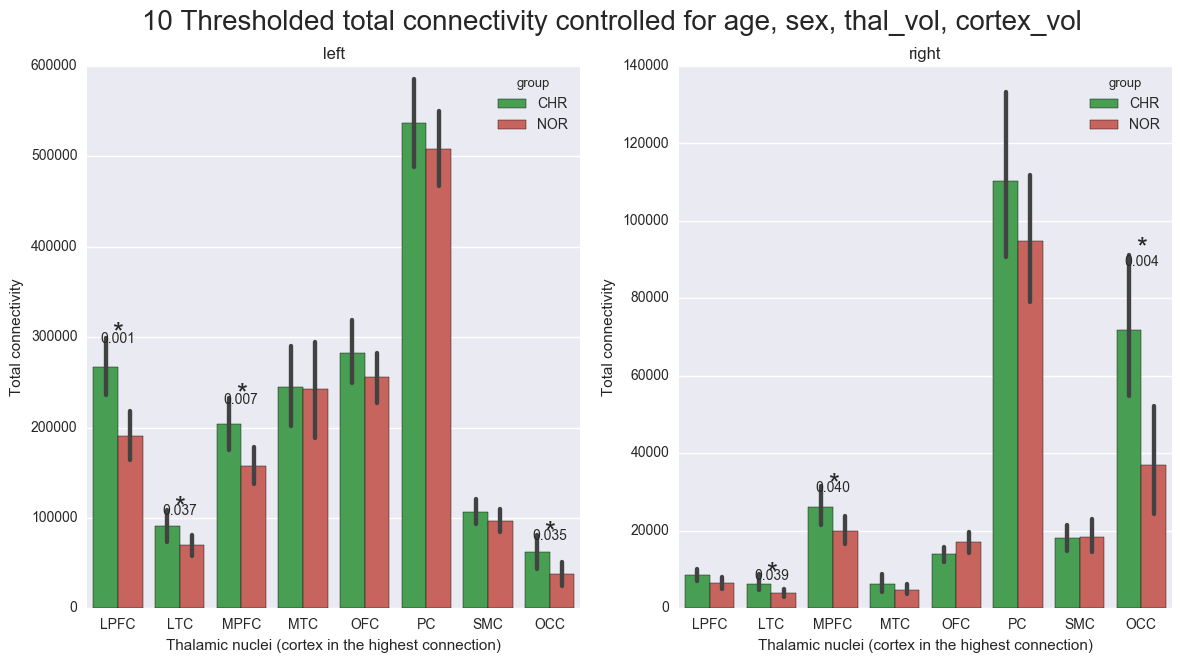

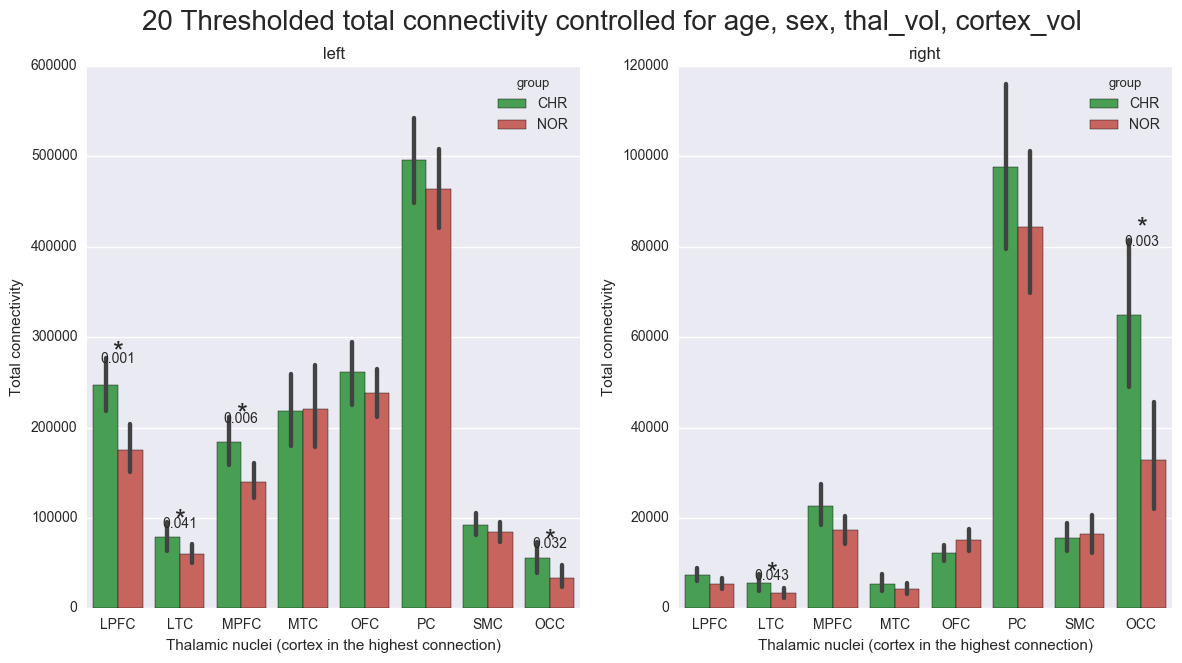

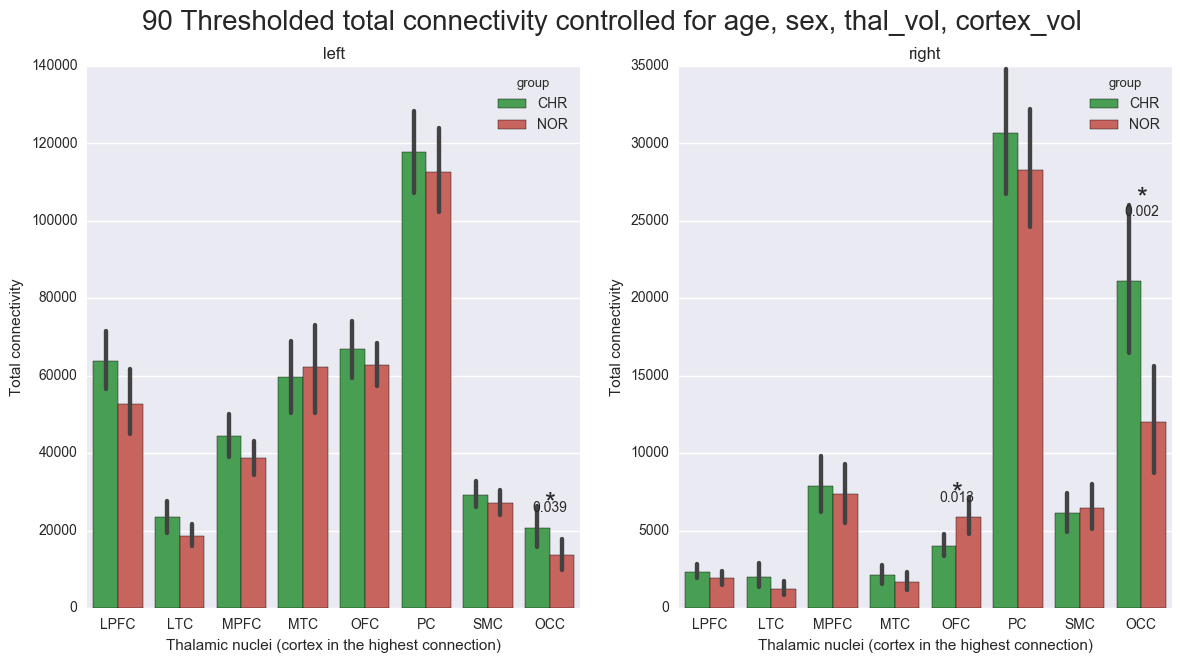

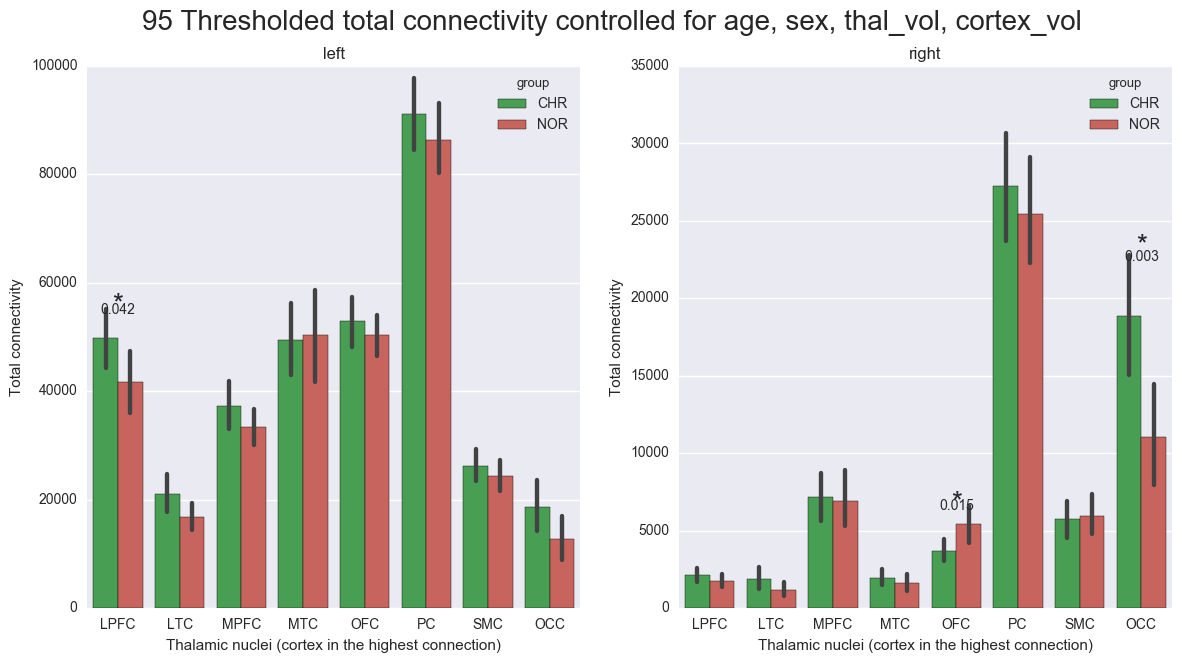

In [87]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'total_connectivity',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Total connectivity')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)

        compare = 'total_connectivity'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            THAL_VOL = x['thalamus_volume']
            CORTEX_VOL = x['cortex_volume']
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX + THAL_VOL + CORTEX_VOL'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle(thr+' Thresholded total connectivity controlled for age, sex, thal_vol, cortex_vol', fontsize=20)
    plt.show()

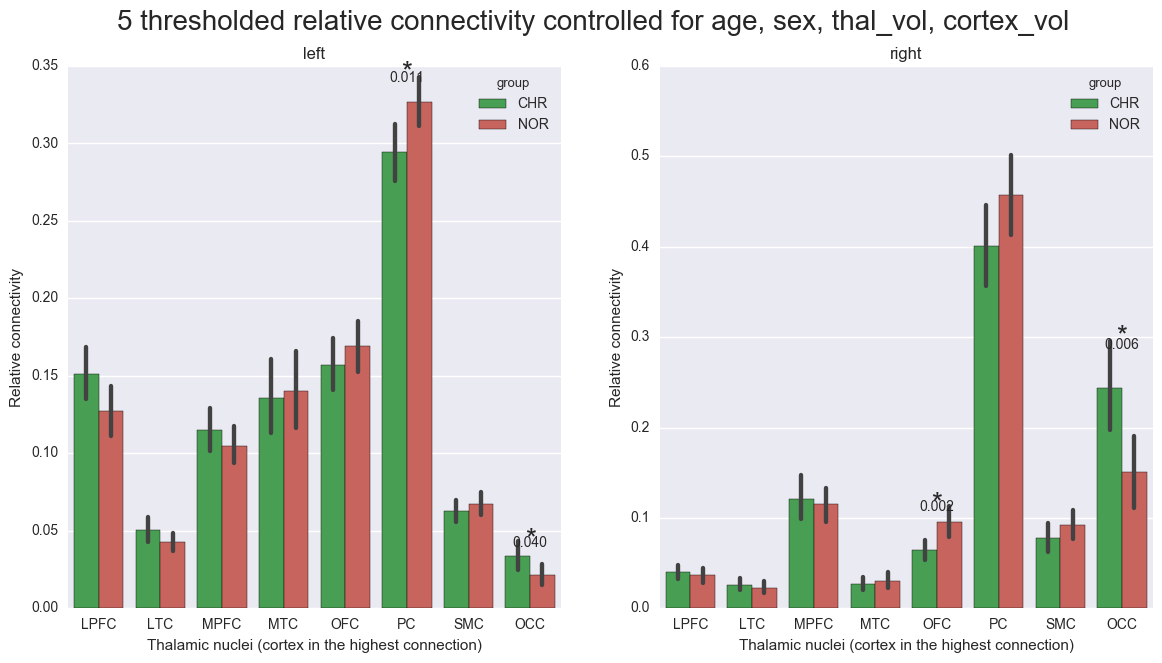

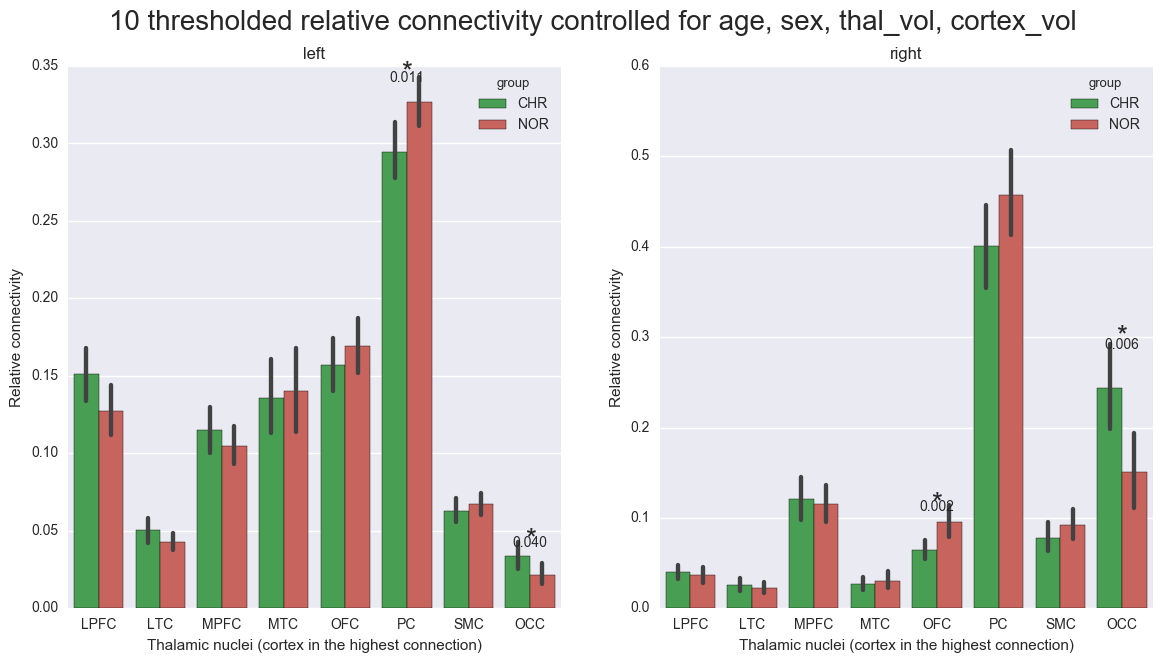

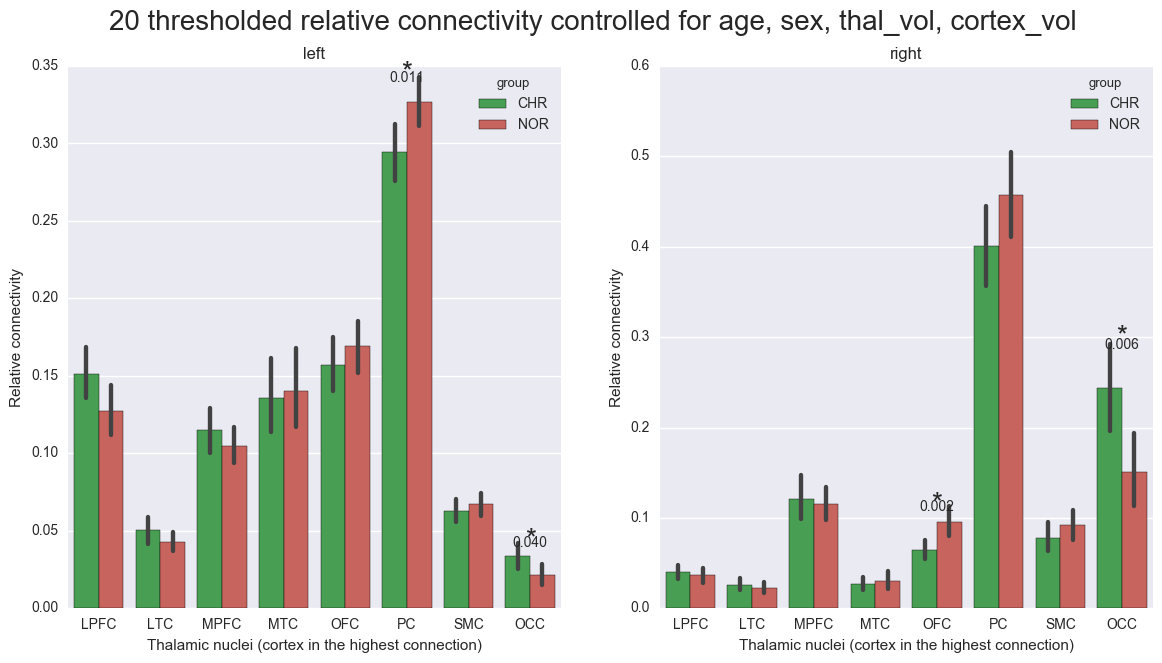

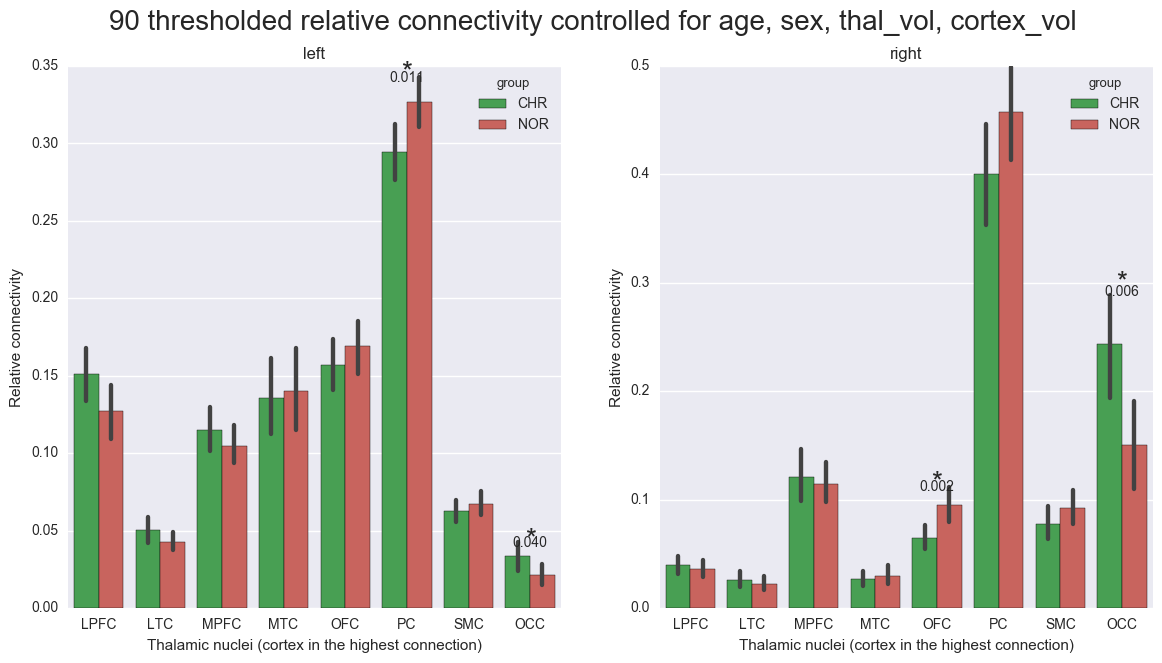

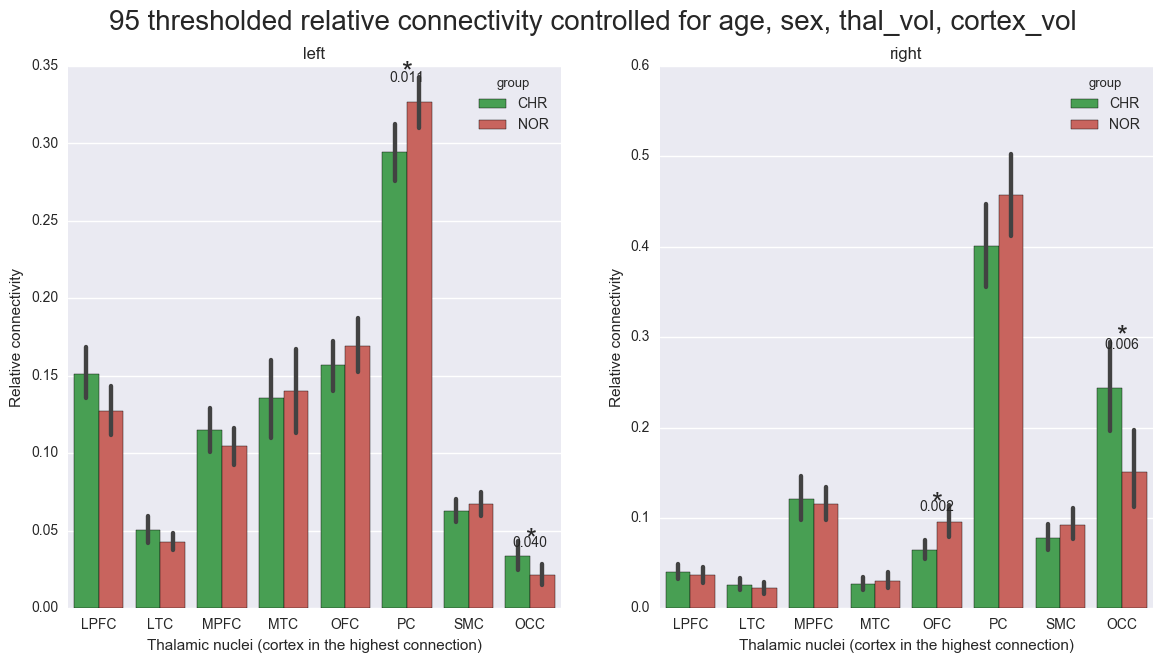

In [88]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'relative_connectivity',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Relative connectivity')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)

        compare = 'relative_connectivity'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            THAL_VOL = x['thalamus_volume']
            CORTEX_VOL = x['cortex_volume']
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX + THAL_VOL + CORTEX_VOL'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle(thr+' thresholded relative connectivity controlled for age, sex, thal_vol, cortex_vol', fontsize=20)
    plt.show()

df_gb = df_matched.groupby(['group','cortex','threshold'])
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(12,5))
    for cortex in df_matched.cortex.unique():
        sns.regplot('age', 
                    'thalamus_seg_mk',
                    df_gb.get_group(('NOR', cortex, thr)),
                    label = cortex,
                    ax=axes[0])
        sns.regplot('age', 
                    'thalamus_seg_mk',
                    df_gb.get_group(('CHR', cortex, thr)),
                    label = cortex,
                    ax=axes[1])
    plt.subplots_adjust(top=0.85)
    axes[0].set_title('NOR')
    axes[1].set_title('CHR')
    fig.suptitle('Correlation between age and MK : {0}'.format(thr), fontsize=30)
    plt.legend()
    plt.show()

df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), col='cortex', hue='group')
    g = g.map(sns.regplot, 'age','thalamus_seg_mk')
    print('Correlation between age and MK : '+thr)
    plt.show()

for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(12,5))
    for roi in df_matched.roi.unique():
        sns.regplot('age', 
                    'Volume_'+thr, 
                    df_matched.groupby('Group').get_group('NOR').groupby('roi').get_group(roi),
                    label = roi,
                    ax=axes[0])
        sns.regplot('age', 
                    'Volume_'+thr, 
                    df_matched.groupby('Group').get_group('CHR').groupby('roi').get_group(roi),
                    label = roi,
                    ax=axes[1])
    plt.subplots_adjust(top=0.85)
    axes[0].set_title('NOR')
    axes[1].set_title('CHR')
    fig.suptitle('Correlation between age and subthalamic volumes'.format(thr), fontsize=30)
    plt.legend()
    plt.show()

for side in 'left','right':
    g = sns.FacetGrid(df_matched.groupby('side').get_group(side)[['cortex',
                                                                  'thalamus_seg_volume',
                                                                  'side',
                                                                  'group',
                                                                  'cortex_volume']].drop_duplicates(), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'cortex_volume')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of cortical volume : '+side, fontsize=30)
    plt.show()

df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'thalamus_seg_mk')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of thalamic mean kurtosis {0} thr'.format(thr), fontsize=30)
    plt.show()

df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'thalamus_seg_volume')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of thalamic mean kurtosis {0} thr'.format(thr), fontsize=30)
    plt.show()

---

# 3. Statistics

In [99]:
cortices = df_matched.roi.unique()

## Comparison of thalamic volumes

In [ ]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print thr, '='*60
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_volume'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

## Comparison of cortical ROI volumes

In [ ]:
df_gb = df_matched.groupby(['side','cortex'])

for side in 'left', 'right':
    print('side', side)
    print('='*80)
    compare = 'cortex_volume'
    for cortex in cortices:
        x = df_gb.get_group((side, cortex))[['subject', 'age', 'group', 'sex', compare]].drop_duplicates()
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:
            print(cortex)
            print(output)
            print()
    print('='*80)
    print()
    print()

## Thalamic nuclei volume left and right together

In [ ]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print thr, '='*60
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_volume'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

## Thalamic nuclei volume left and right separately

In [ ]:
for thr in '10', '90', '95':
    for side in 'left', 'right':
        print('thr', thr)
        print('side', side)
        print('='*80)
        compare = 'Volume_'+thr
        for cortex in cortices:
            x = df_matched.groupby('roi').get_group(cortex).groupby('side').get_group(side)
            GROUP = x['Group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

## Mean kurtosis in thalamic nuclei left and right together

> 10 thrP

In [ ]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print(thr, '='*60)
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_mk'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()